In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 


In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid =  272622914

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
search_result = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC').download_all().stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

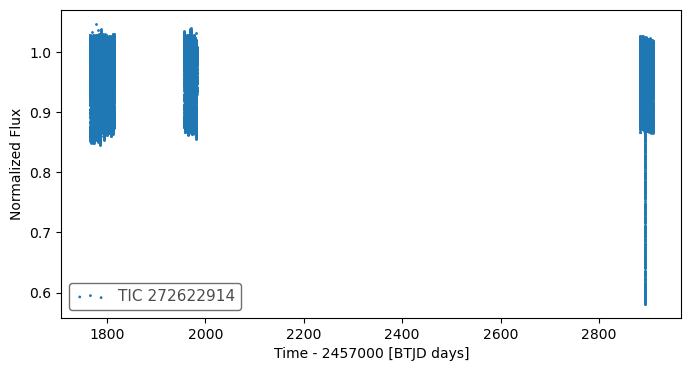

In [5]:
# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# t0 = 2337.376
# period_triple = 0.774

mask = (time > 2893.16-1) & (time < 2893.16+1) 

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})


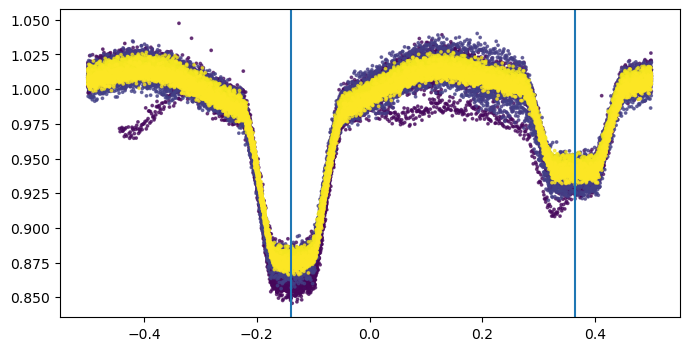

In [6]:
# define the orbital period and the t0 

period = 1.31568

t0_primary = 1766.775
t0_secondary = 1766.122

t0_for_plotting = 0 # keep 0 for plotting purposes

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], 0, period)[0])
plt.axvline(etv_functions.phase_data([t0_secondary], 0, period)[0])


### Now that the data is ready we can start 

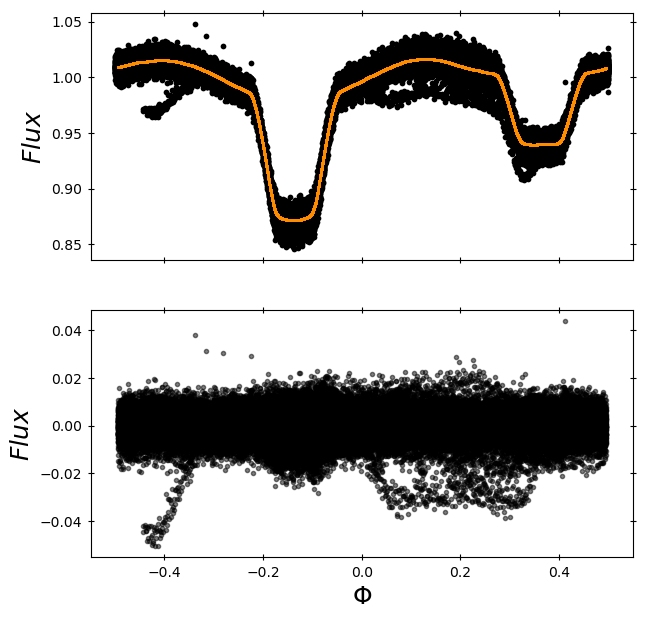

In [7]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, 0, data)



10 63716 901
reached the end
10 62474 901
reached the end
10 62302 901
reached the end
10 62267 901
reached the end
10 62257 901
reached the end


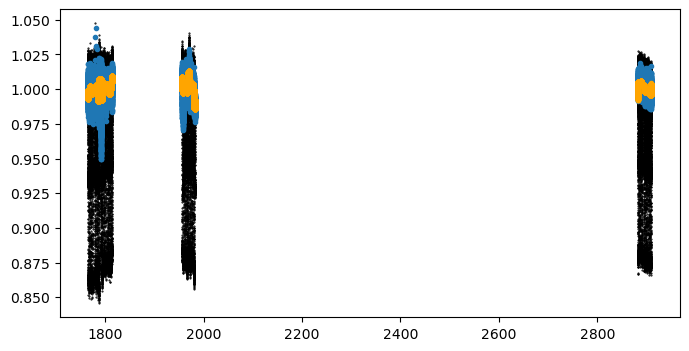

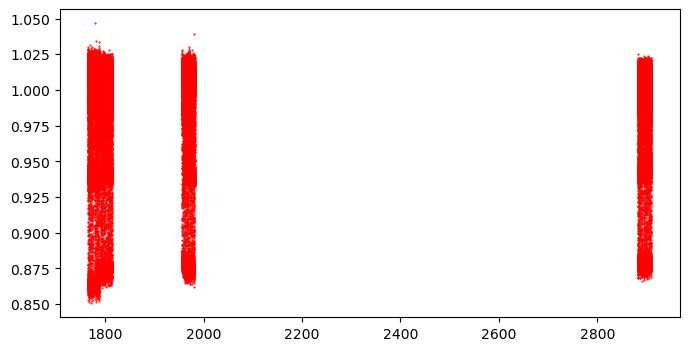

In [8]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)

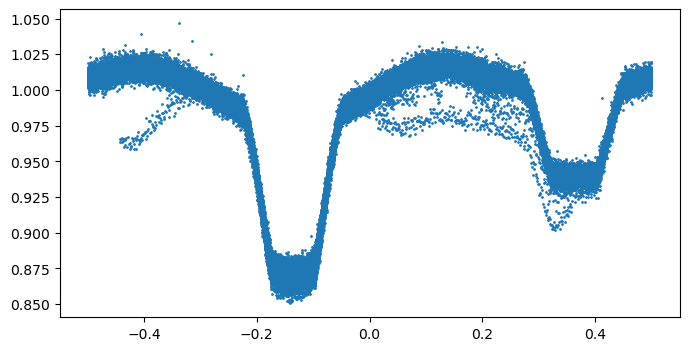

In [9]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   1766.775 -0.13927398759571824
Secondary: 1766.122 0.36440471847261147


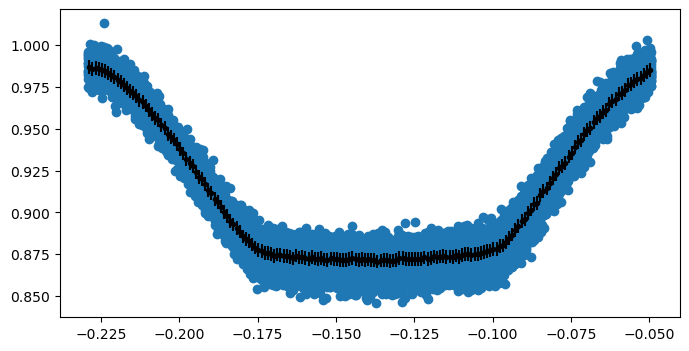

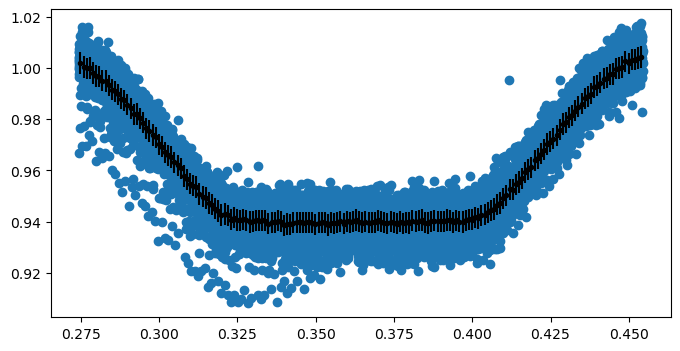

In [11]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], 0, period)[0]  # convet to time in phase
midpoint_s =  etv_functions.phase_data([t0_secondary], 0, period)[0]

print('Primary:  ', t0_primary, midpoint_p)
print('Secondary:', t0_secondary, midpoint_s)

# change depending on the width of the eclipses
window_width = 0.08  # original from Nora: 0.08


data_primary = data[(data['phase'] > midpoint_p - window_width) & (data['phase'] < midpoint_p + window_width) ]
data_secondary = data[(data['phase'] > midpoint_s - window_width) & (data['phase'] < midpoint_s + window_width) ]

ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)
ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


# -- -- -- -- -- -- -- -- -- 

fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_primary.phase, data_primary.flux, zorder = -2)
plt.show()

# -- -- -- -- -- -- -- -- -- 
fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned_s, flux_binned_s, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_secondary.phase, data_secondary.flux, zorder = -2)
plt.show() 

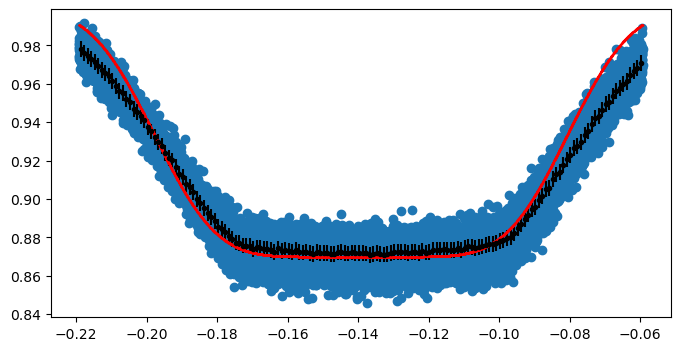

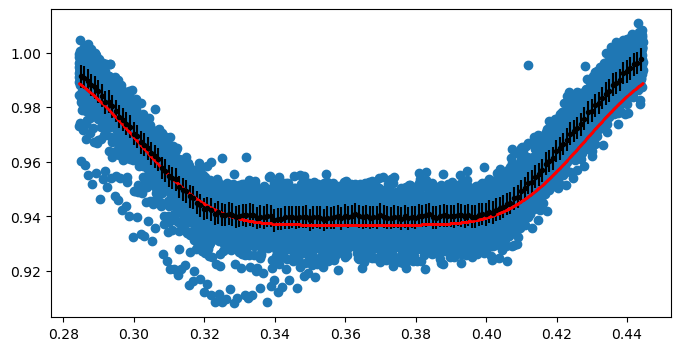

In [31]:

# you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.13, midpoint_p, 0.035, 3.8]
start_vals_s = [1, -0.063, midpoint_s, 0.04, 3]

# - - -- - 

etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.54it/s]


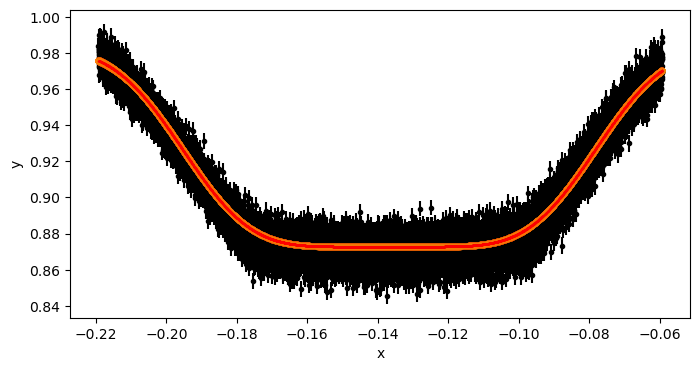

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:49<00:00,  4.35it/s]


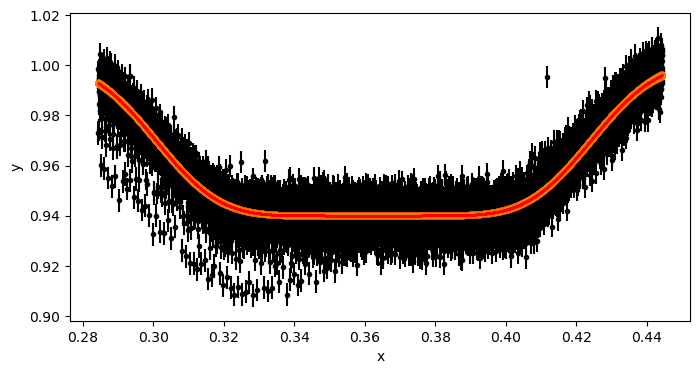

In [32]:
# run the initial model fit using MCMC for the primary and secondary eclipses 

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)

870

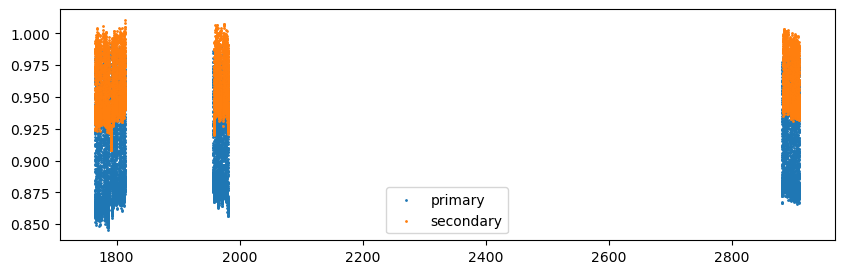

In [36]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1766.122 1.31568 1766.122


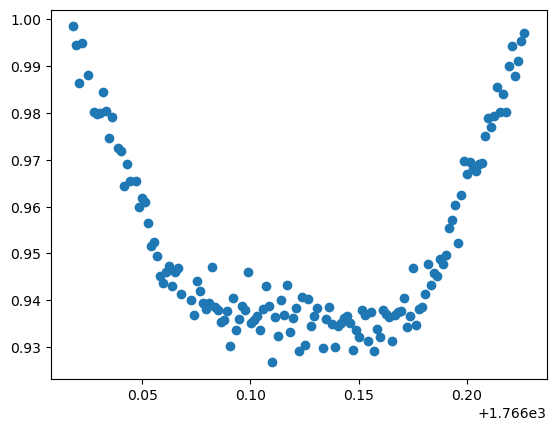

1766.122 1.31568 1767.43768


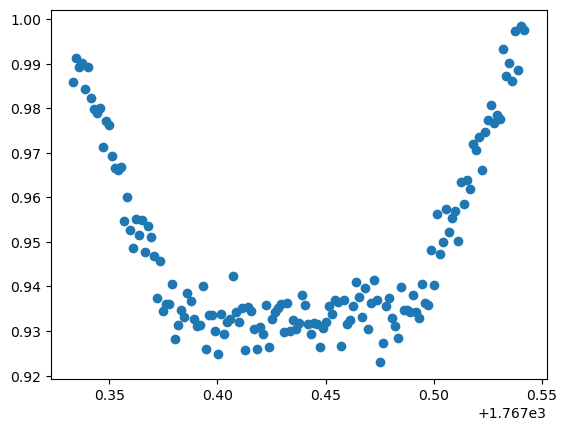

1766.122 1.31568 1768.7533600000002


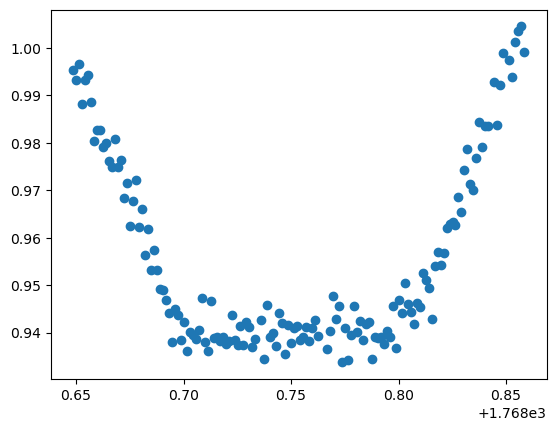

In [37]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
        
    transit_time = t0_secondary+(period*i)
    x = np.array(data_secondary.time)
    y = np.array(data_secondary.flux) 
    yerr = np.array(data_secondary.err)
    
    print (t0_secondary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y)
    plt.show()

Creating new manifest file
1766.775 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.15it/s]


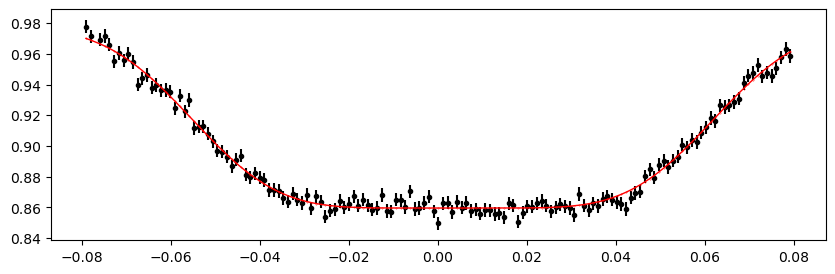

1768.09068 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.15it/s]


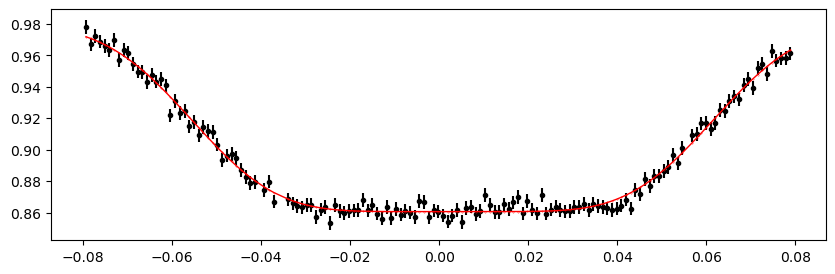

1769.4063600000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.48it/s]


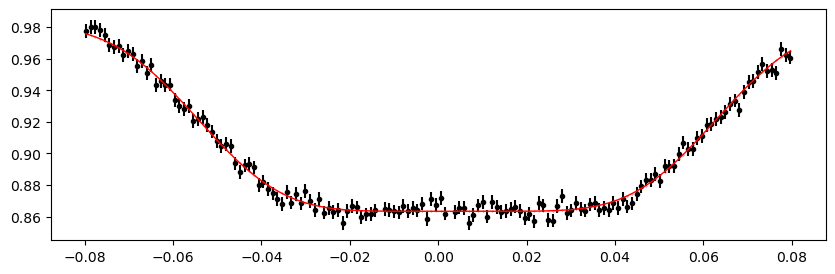

1770.72204 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.26it/s]


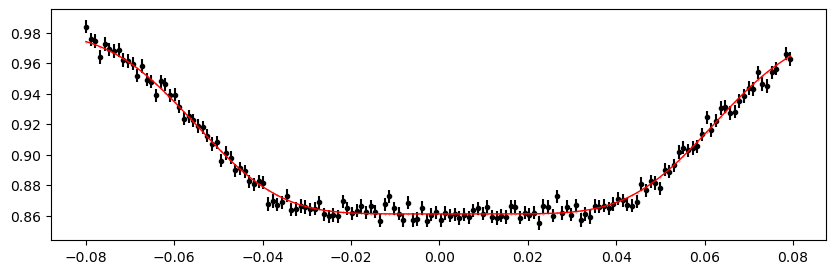

1772.03772 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.43it/s]


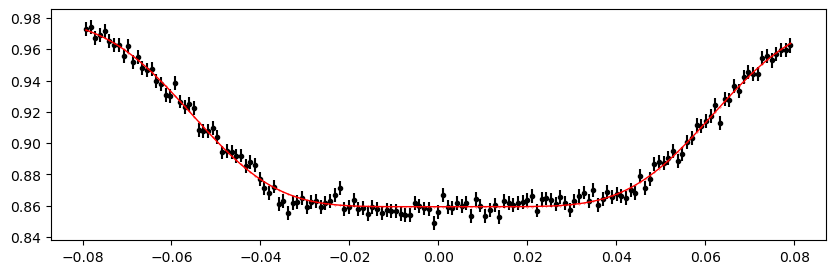

1773.3534000000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.30it/s]


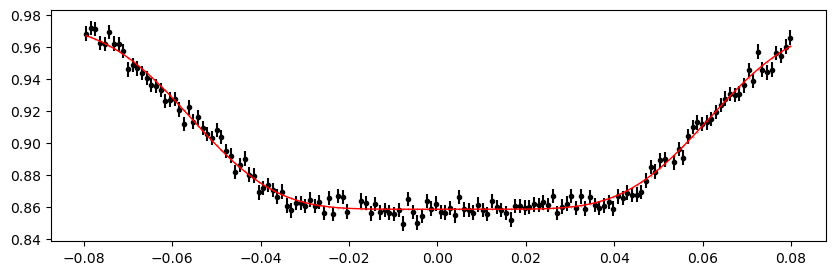

1774.6690800000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.27it/s]


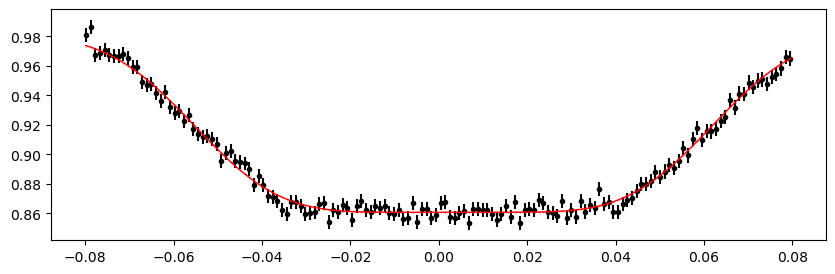

1778.6161200000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.36it/s]


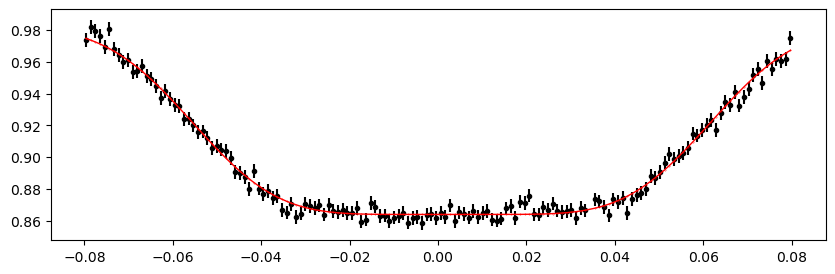

1779.9318 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.89it/s]


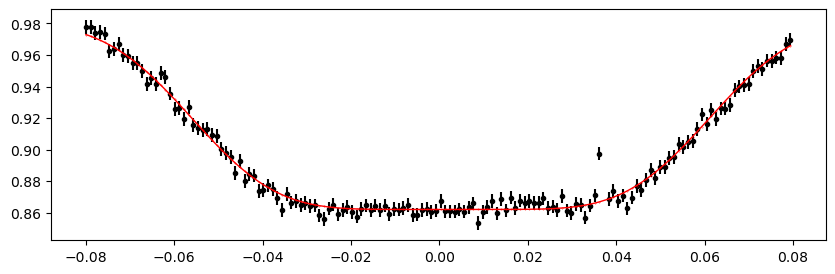

1781.24748 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.11it/s]


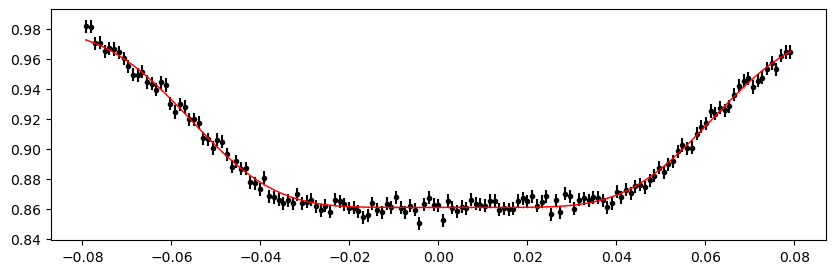

1782.5631600000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.58it/s]


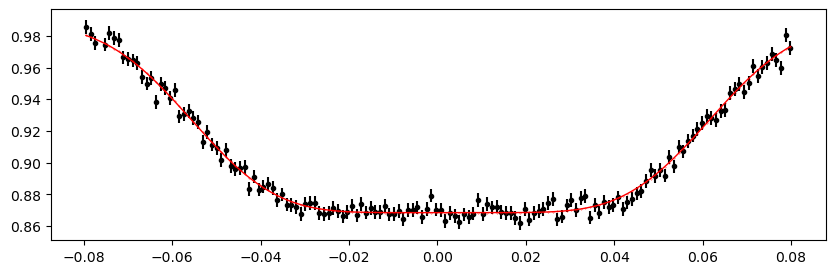

1783.87884 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.41it/s]


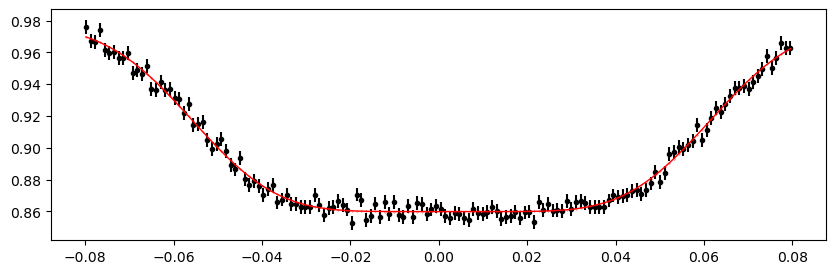

1785.19452 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.00it/s]


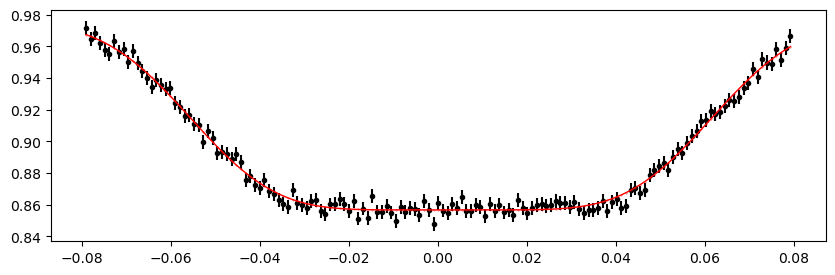

1786.5102000000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.26it/s]


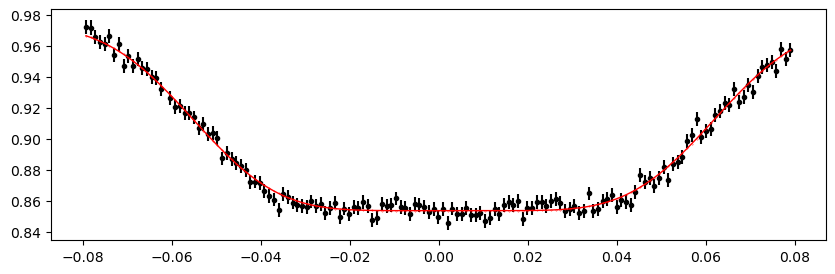

1787.82588 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.96it/s]


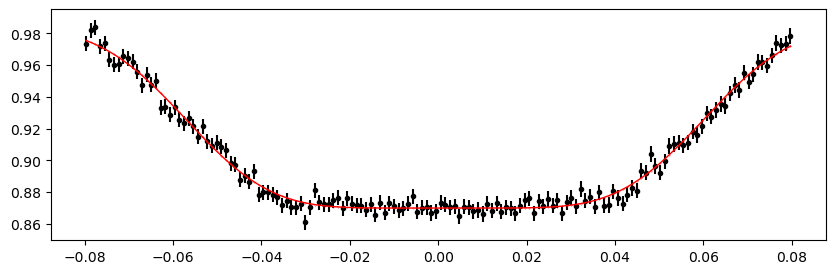

1791.77292 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.01it/s]


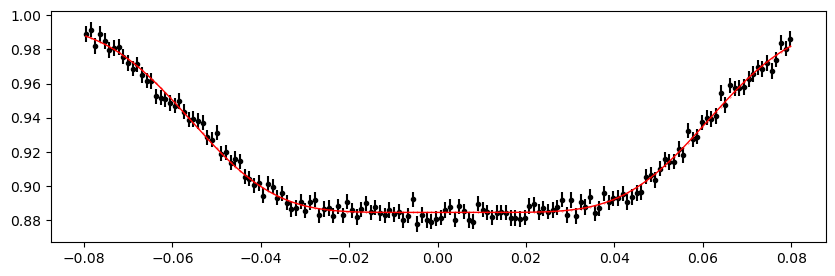

1793.0886 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.32it/s]


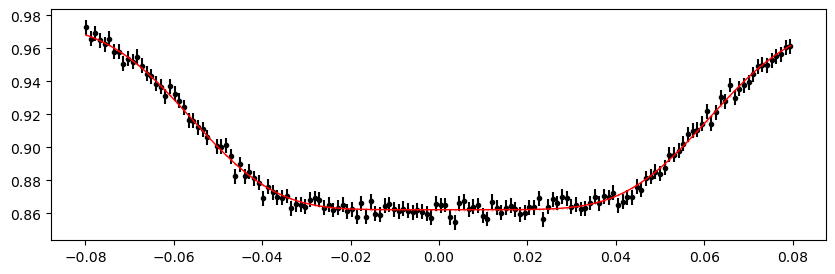

1794.4042800000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.31it/s]


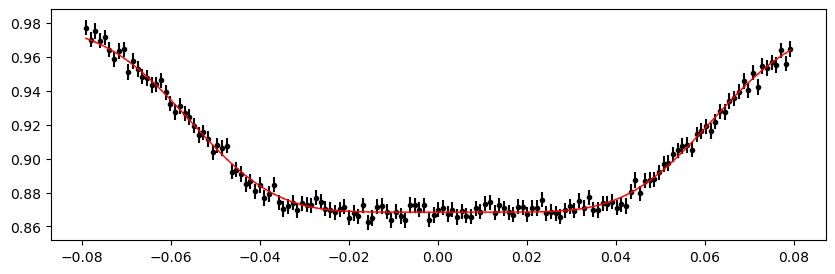

1795.7199600000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.65it/s]


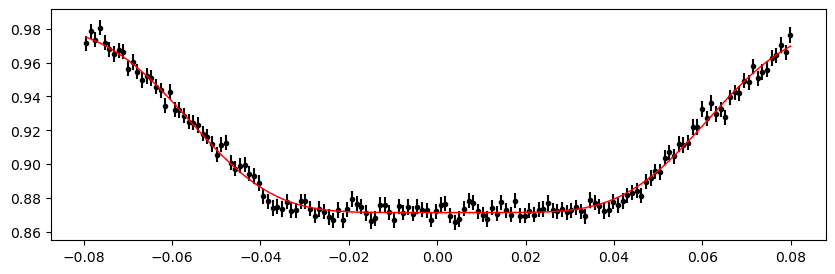

1797.03564 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.44it/s]


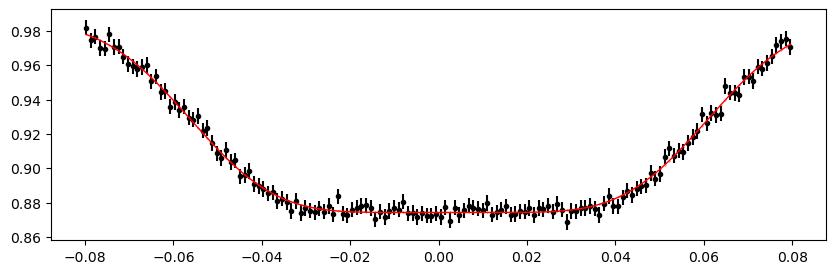

1798.35132 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.67it/s]


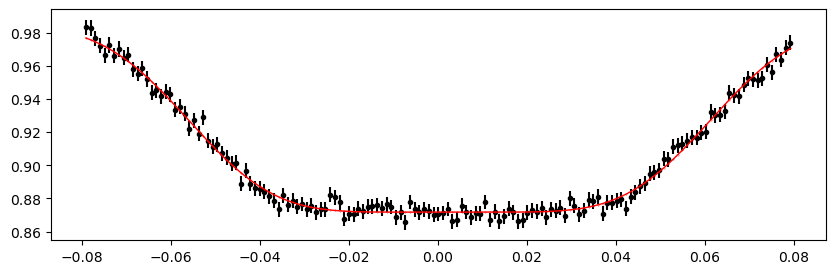

1799.6670000000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.56it/s]


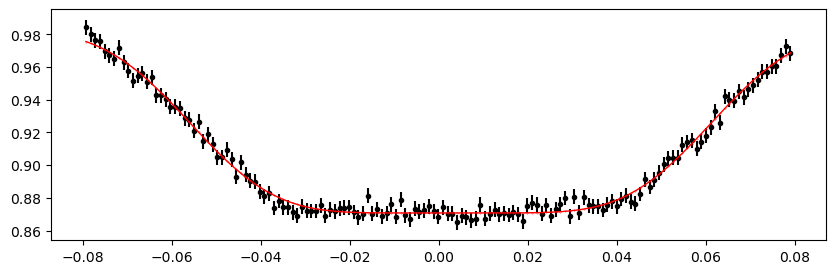

1800.98268 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.12it/s]


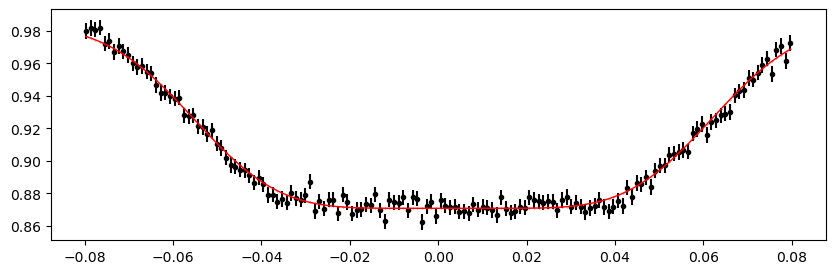

1803.6140400000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.91it/s]


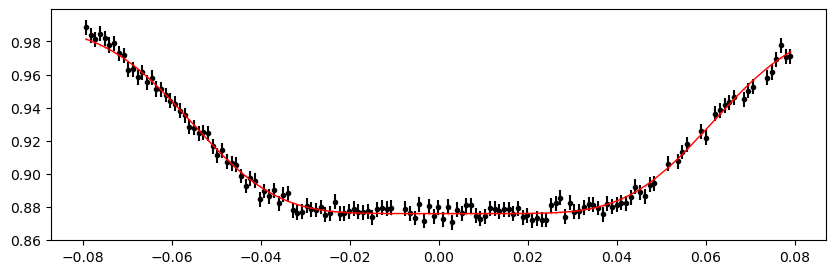

1804.92972 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.30it/s]


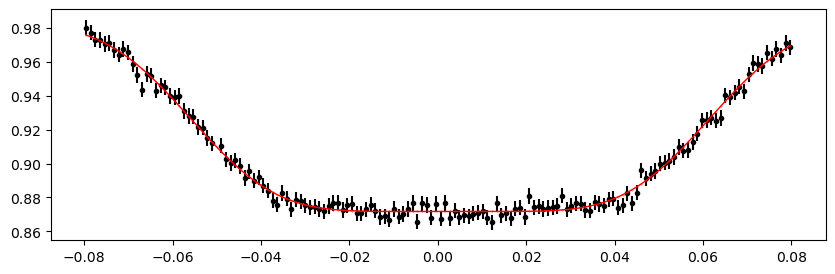

1806.2454 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.90it/s]


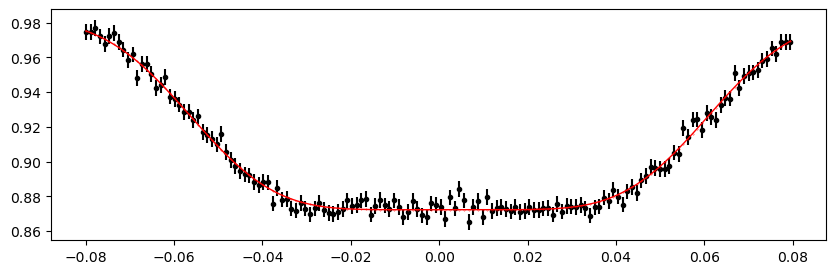

1807.5610800000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.02it/s]


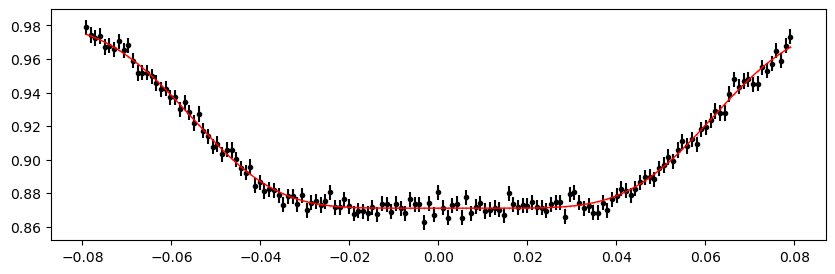

1808.87676 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.11it/s]


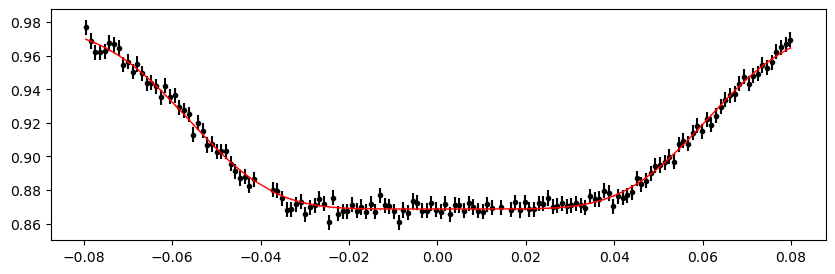

1810.19244 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.19it/s]


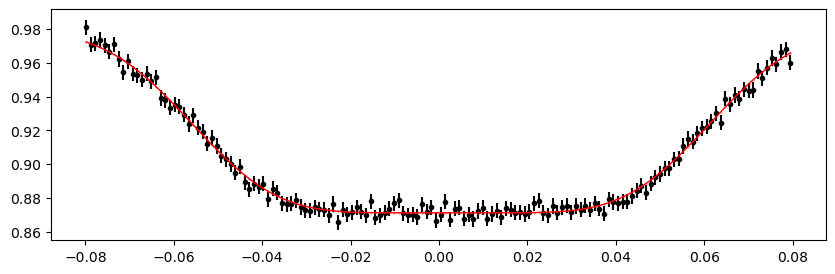

1811.5081200000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.23it/s]


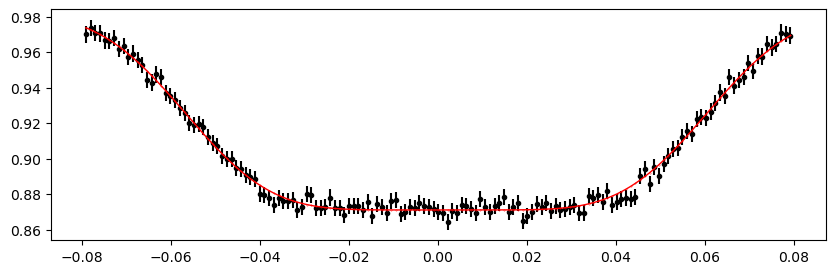

1812.8238000000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.80it/s]


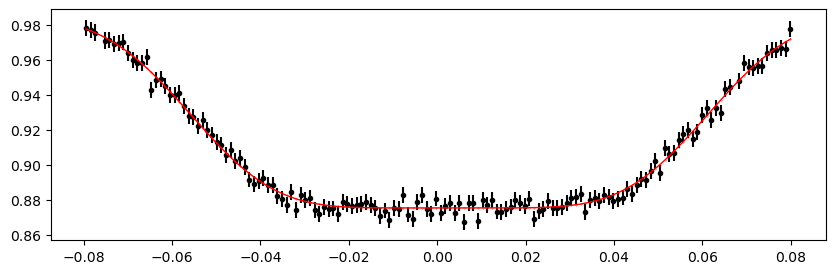

1814.13948 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.50it/s]


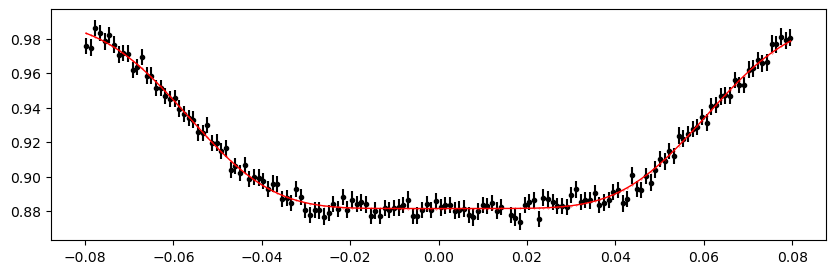

1956.2329200000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.29it/s]


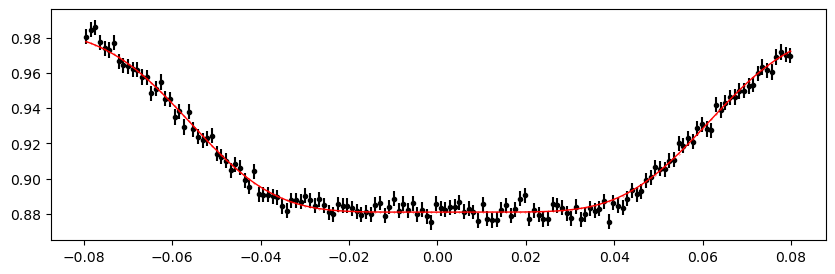

1958.86428 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.17it/s]


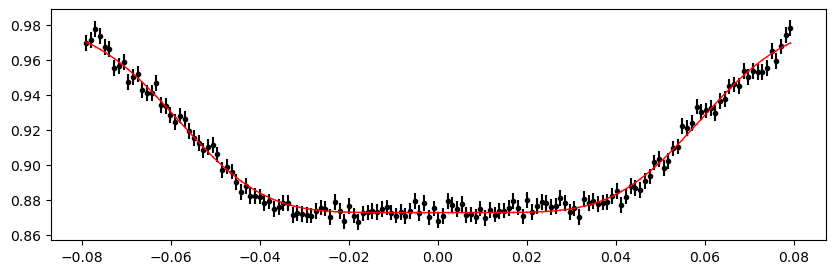

1960.1799600000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.66it/s]


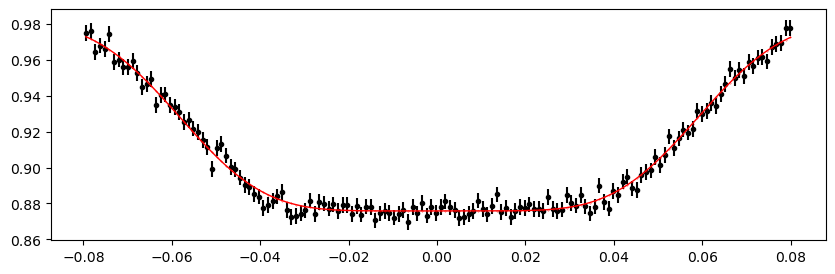

1961.49564 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.28it/s]


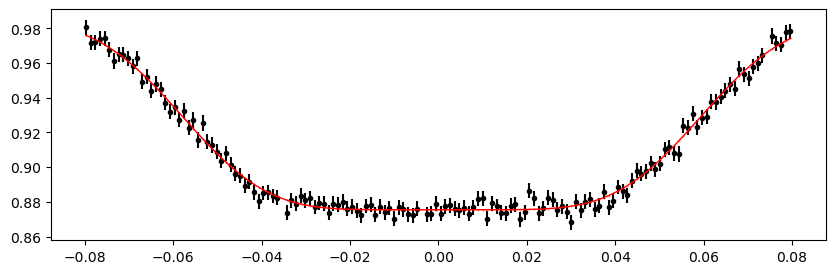

1962.81132 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.75it/s]


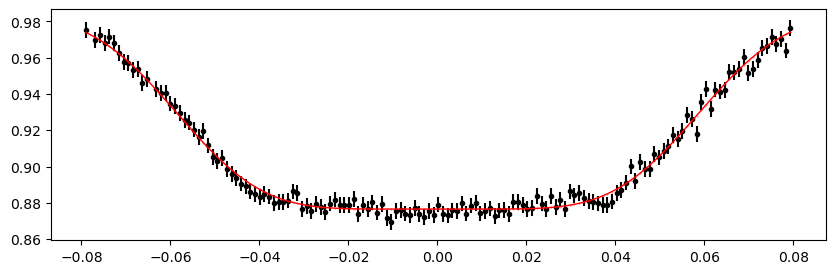

1964.1270000000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.49it/s]


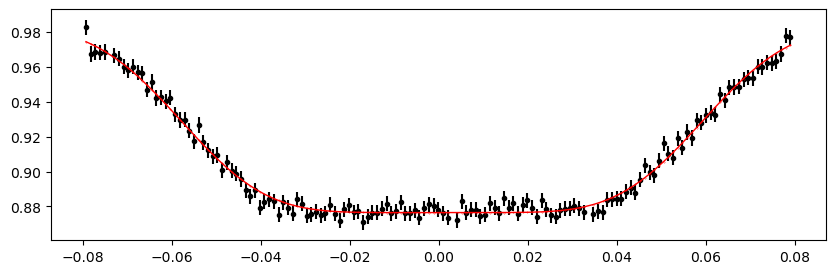

1965.44268 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.50it/s]


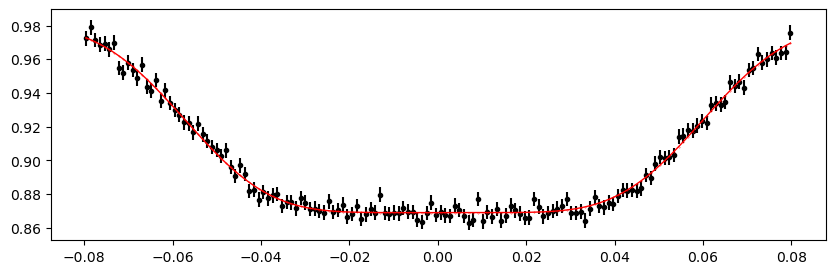

1966.75836 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.70it/s]


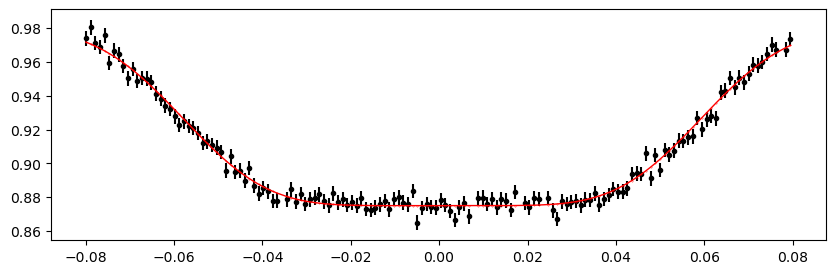

1968.07404 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.26it/s]


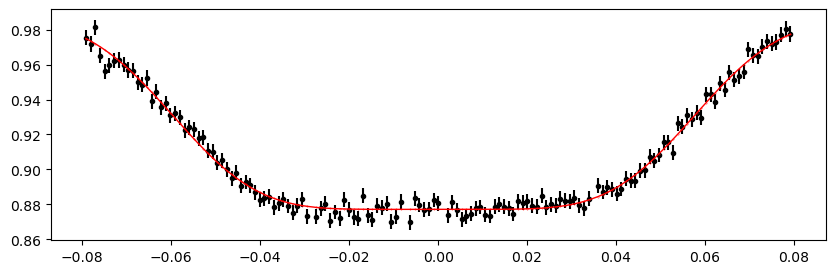

1969.3897200000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.16it/s]


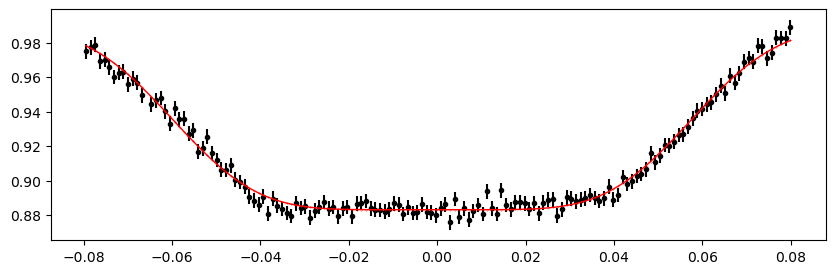

1972.02108 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.43it/s]


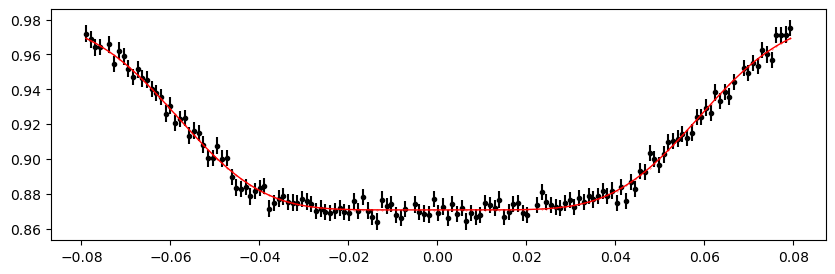

1973.3367600000001 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.40it/s]


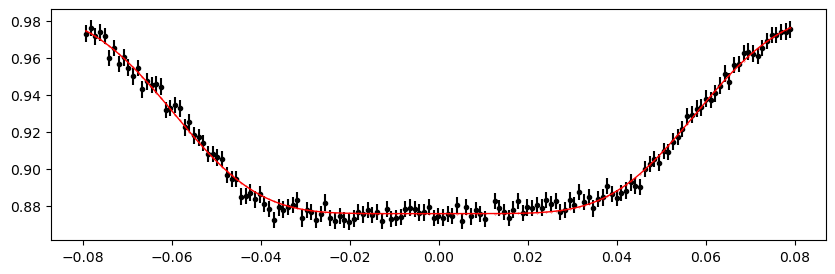

1974.65244 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.10it/s]


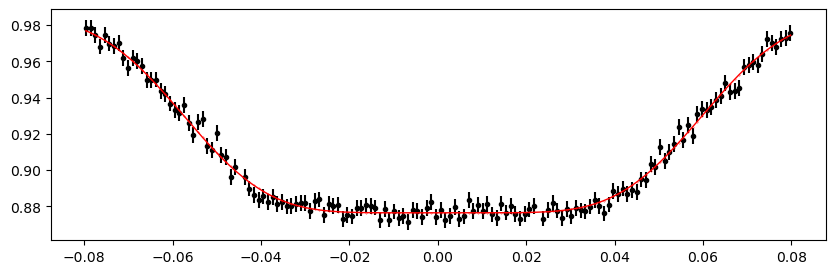

1975.96812 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.87it/s]


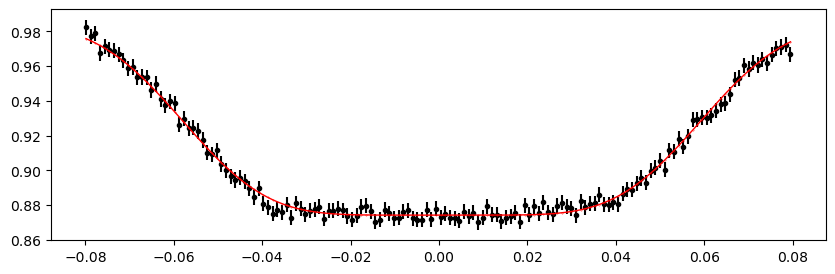

1977.2838000000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.16it/s]


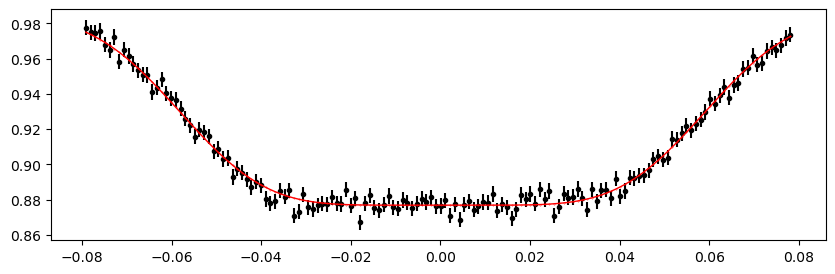

1978.59948 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.71it/s]


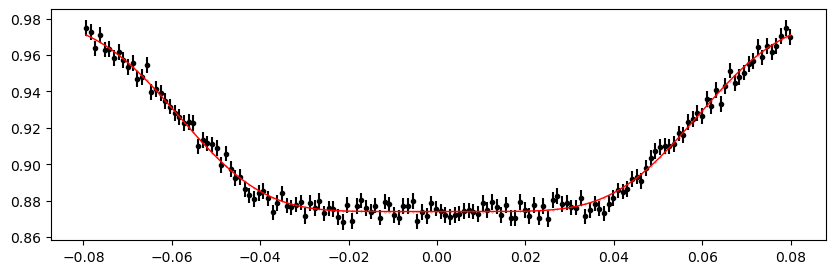

1979.91516 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.28it/s]


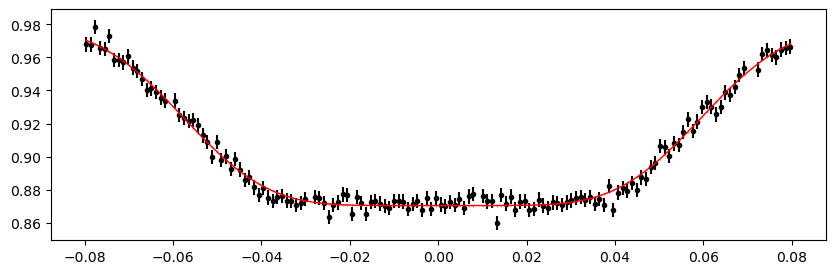

1981.2308400000002 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.27it/s]


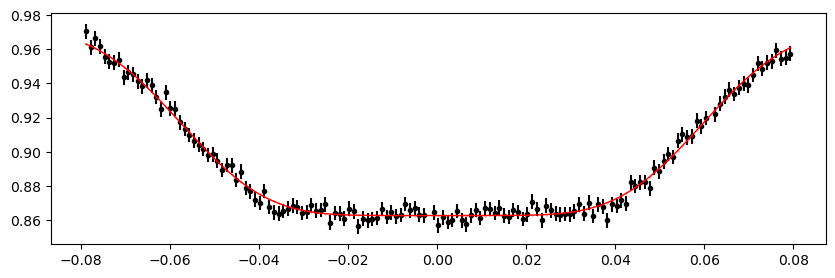

2882.4716399999998 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.36it/s]


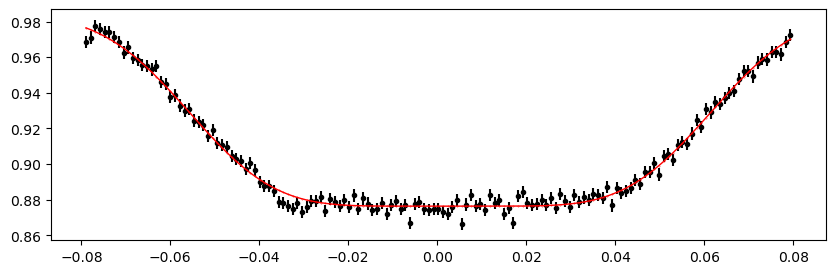

2883.7873200000004 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.86it/s]


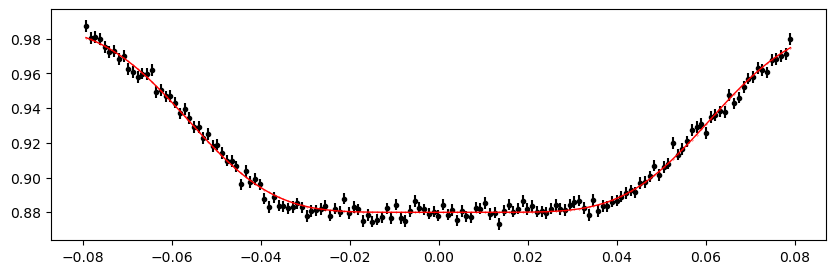

2885.103 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.98it/s]


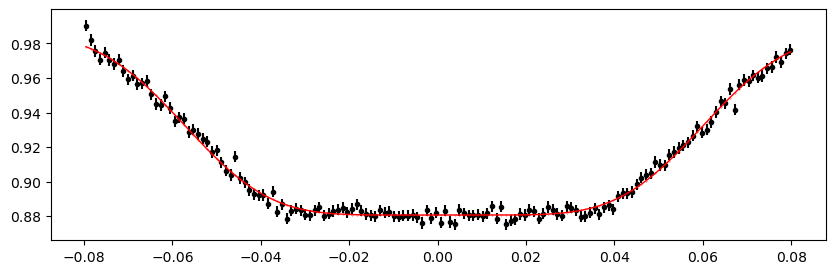

2886.4186799999998 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.45it/s]


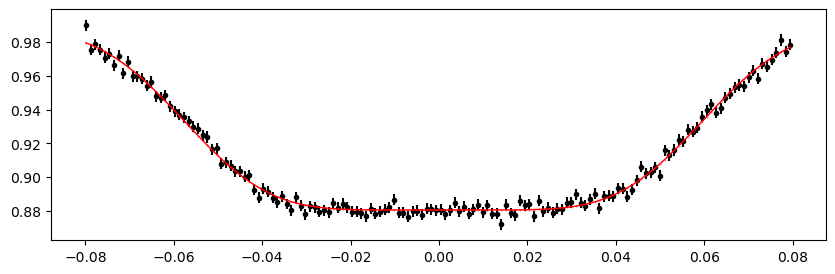

2887.7343600000004 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.17it/s]


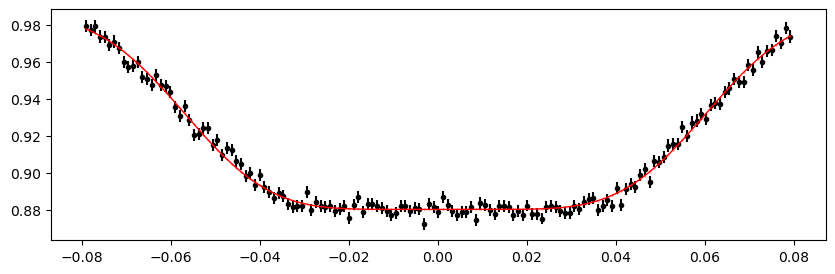

2889.05004 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.14it/s]


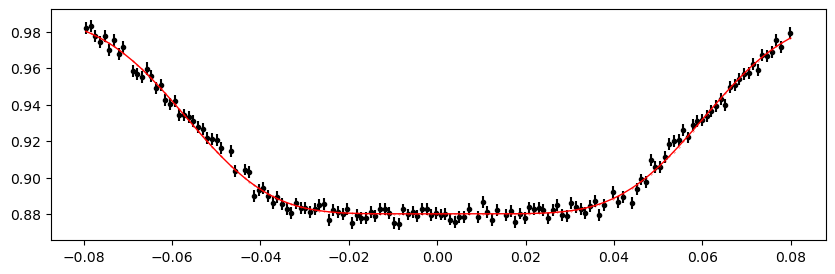

2890.36572 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.09it/s]


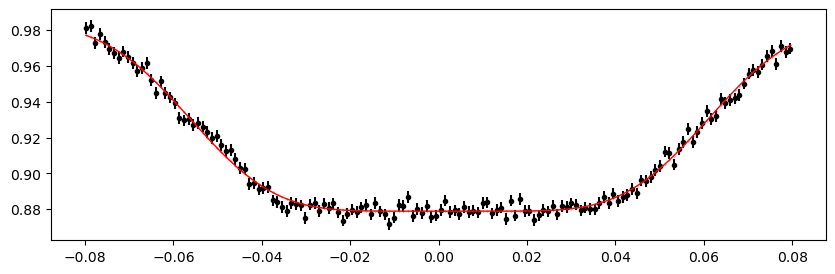

2891.6814000000004 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.64it/s]


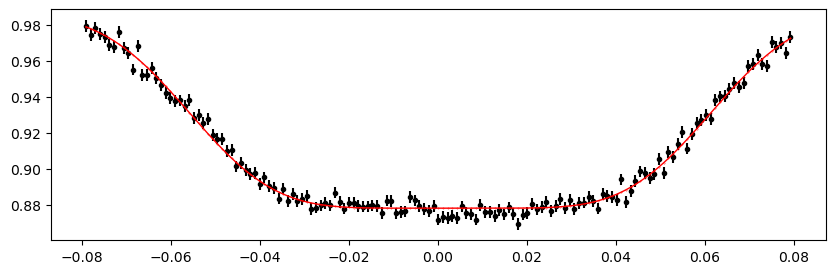

2894.31276 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.19it/s]


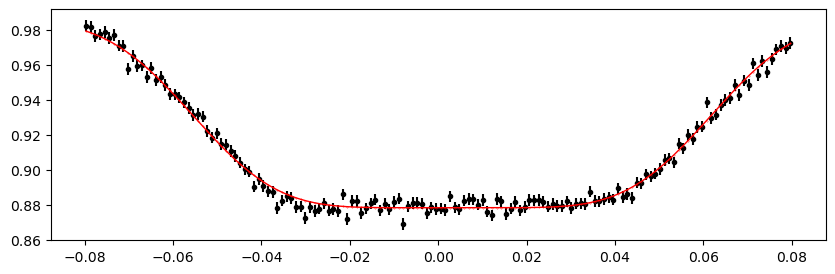

2895.62844 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.53it/s]


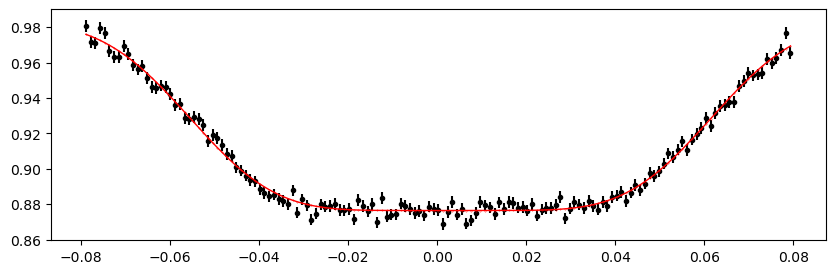

2896.94412 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.20it/s]


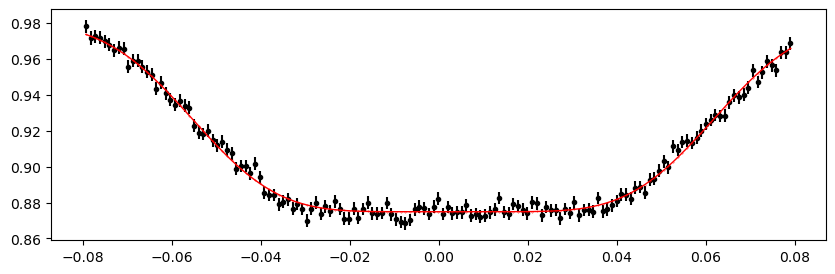

2898.2598 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.44it/s]


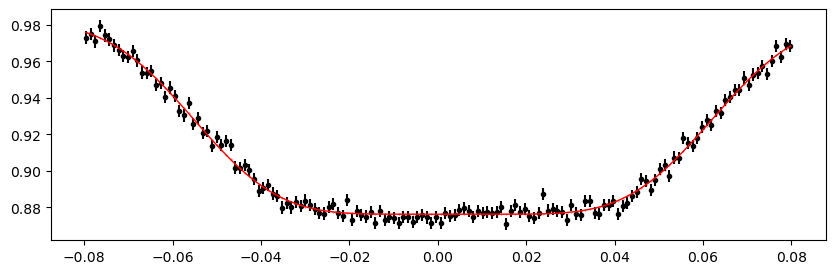

2899.57548 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.51it/s]


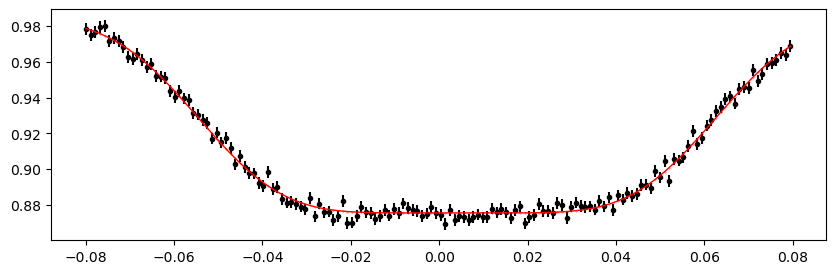

2900.89116 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.34it/s]


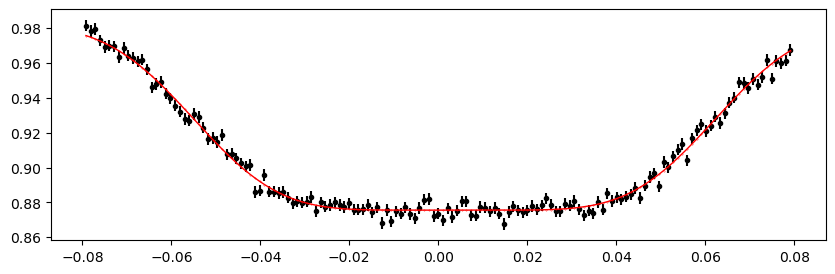

2902.20684 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.31it/s]


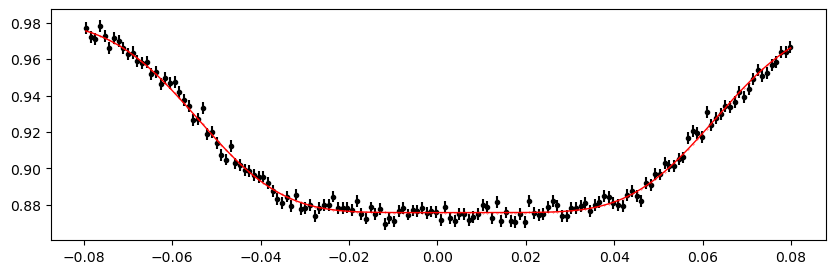

2903.52252 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 456.03it/s]


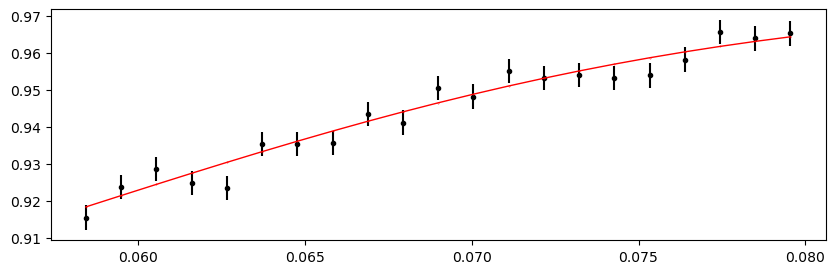

2904.8382 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.36it/s]


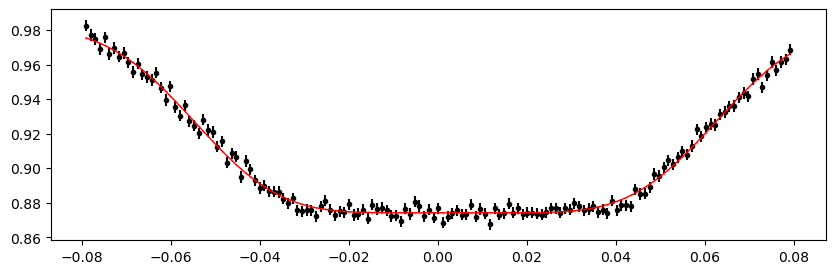

2906.15388 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.33it/s]


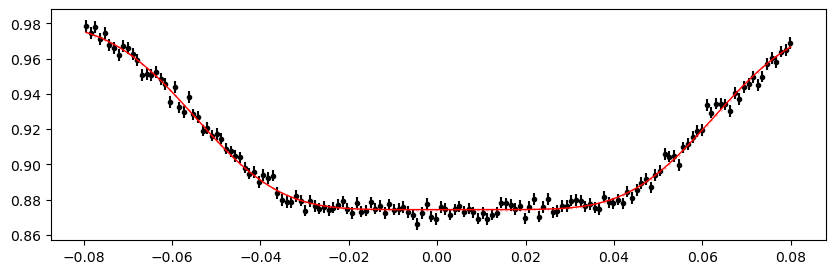

2907.46956 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.77it/s]


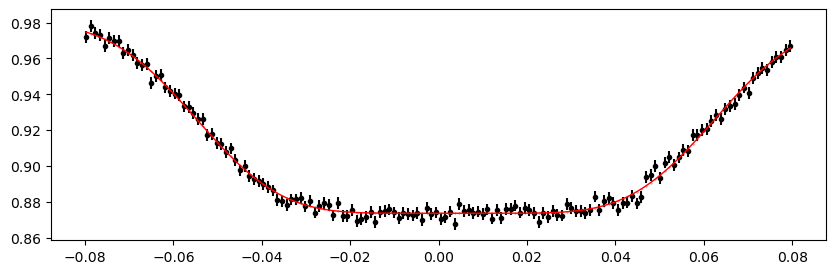

2908.78524 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.06it/s]


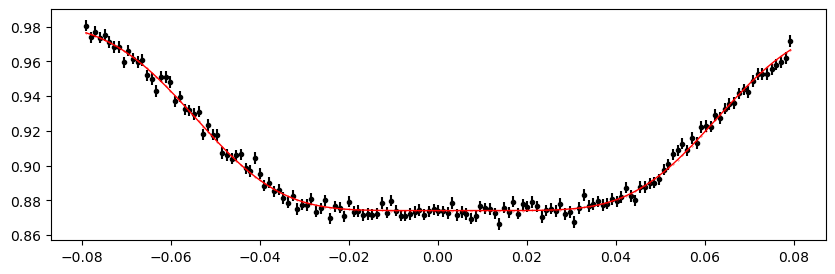

2910.10092 0.9827229668492721 -0.10989307961463854 -0.1368497677199819


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.31it/s]


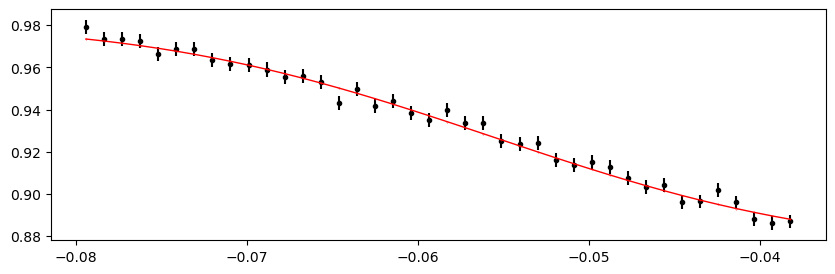

Creating new manifest file
1766.122 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.37it/s]


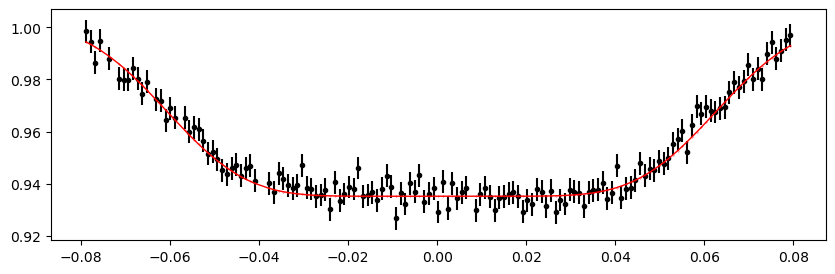

1767.43768 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.74it/s]


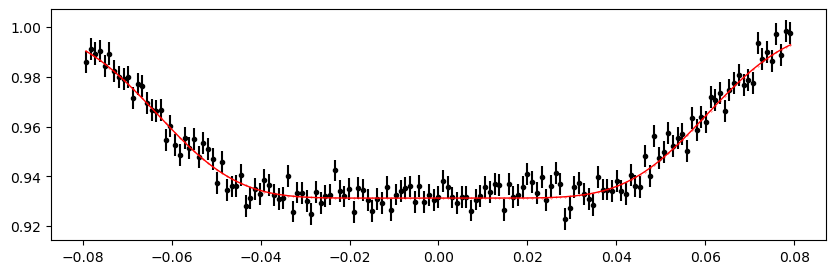

1768.7533600000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.03it/s]


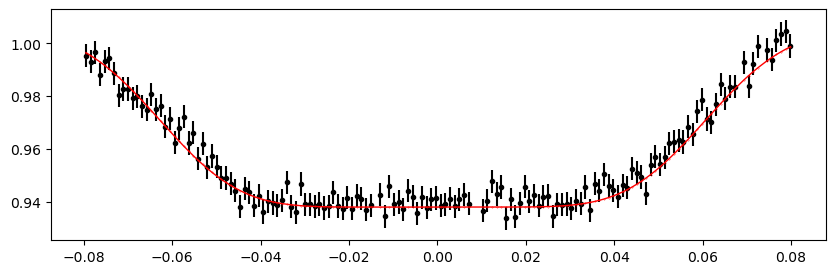

1770.06904 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.28it/s]


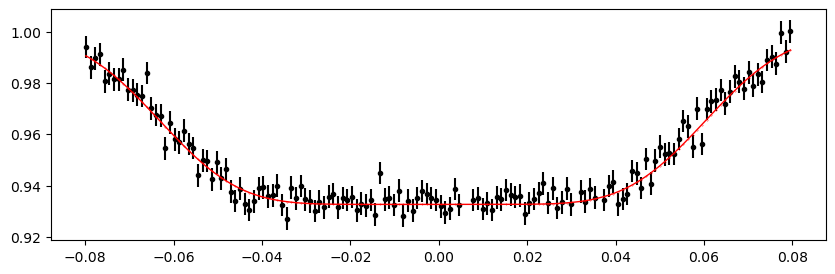

1771.38472 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.10it/s]


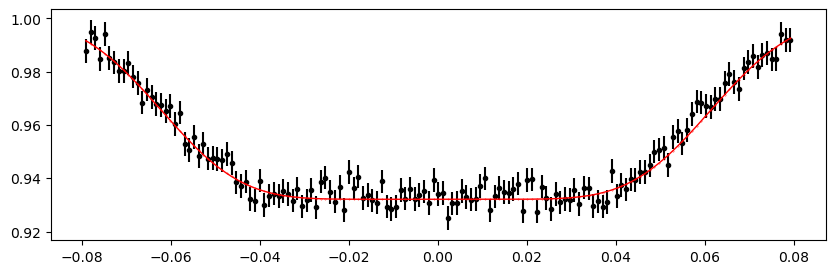

1772.7004000000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.54it/s]


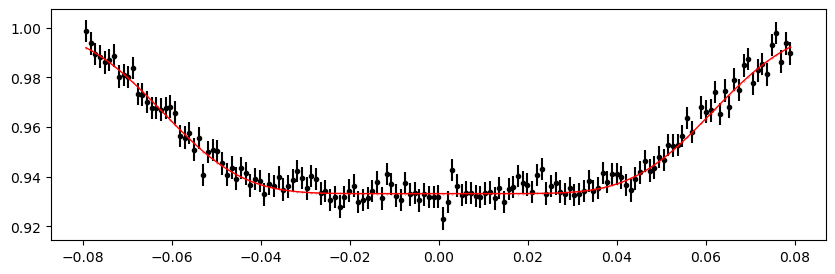

1774.01608 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.06it/s]


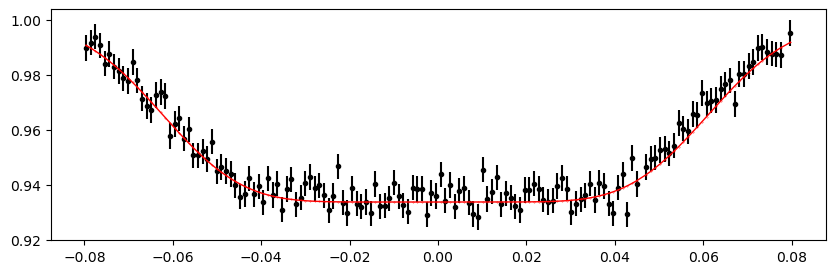

1777.9631200000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.63it/s]


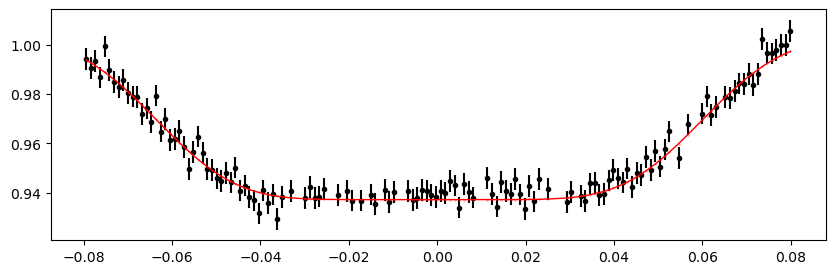

1779.2788 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.82it/s]


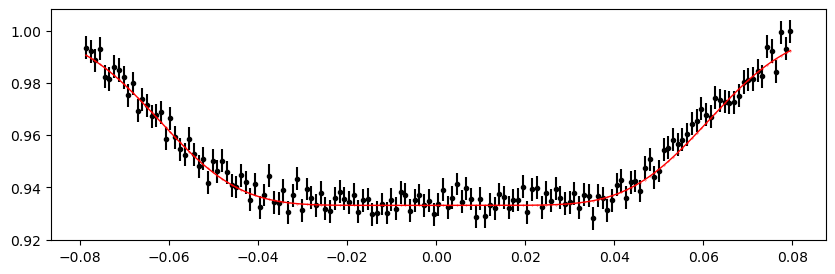

1780.59448 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.09it/s]


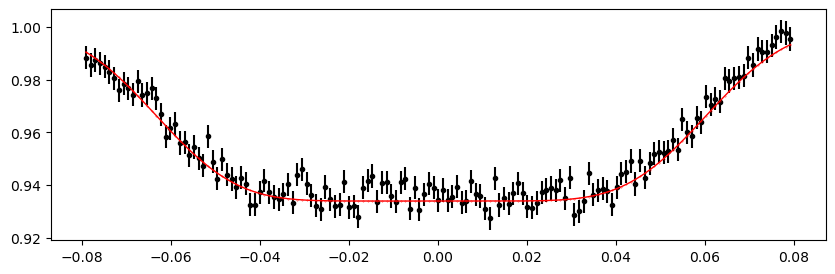

1781.9101600000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.41it/s]


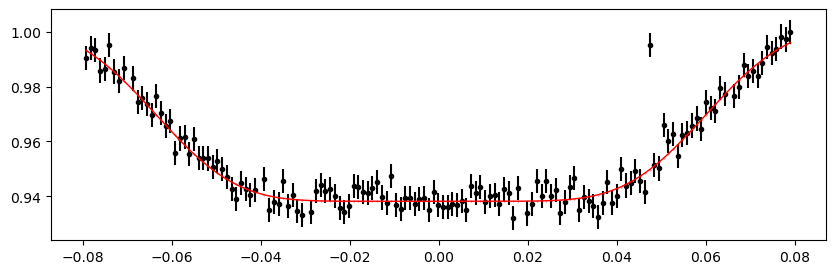

1783.22584 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.95it/s]


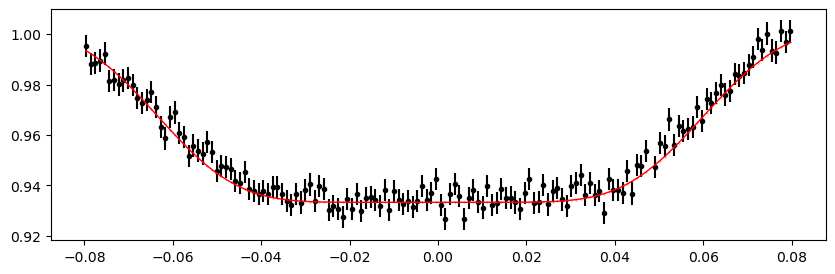

1784.54152 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.21it/s]


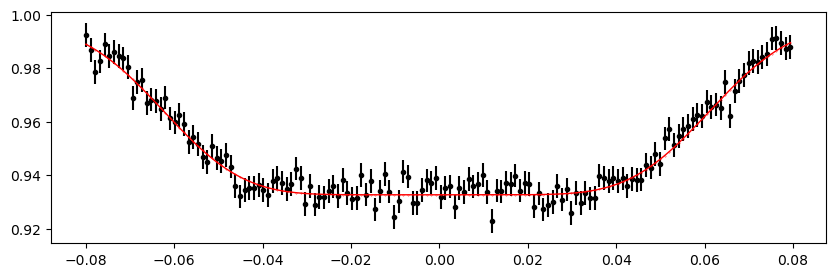

1785.8572000000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.51it/s]


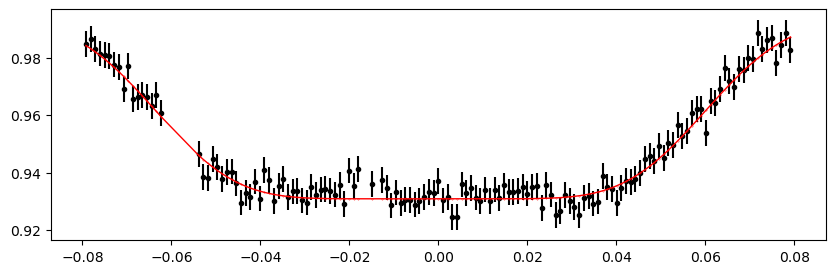

1787.17288 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.93it/s]


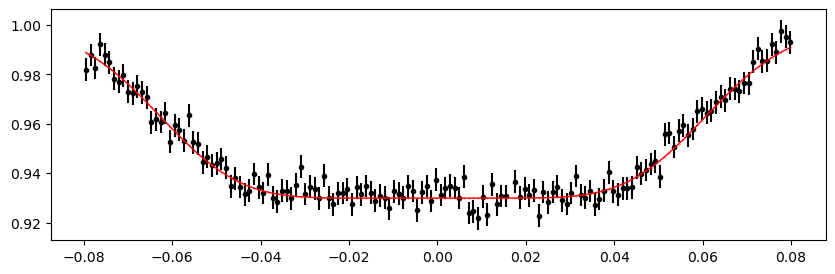

1791.11992 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.32it/s]


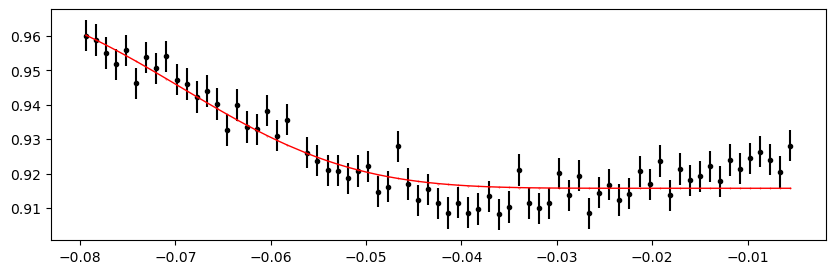

1792.4356 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.18it/s]


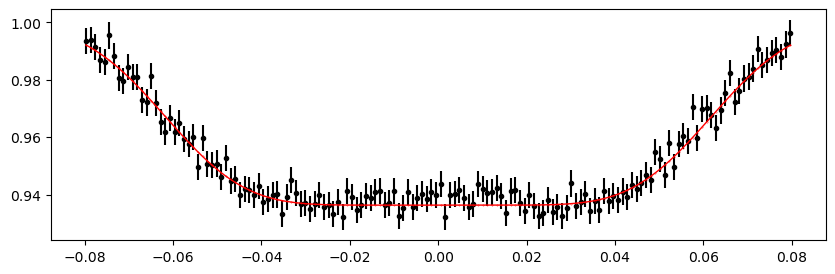

1793.7512800000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.78it/s]


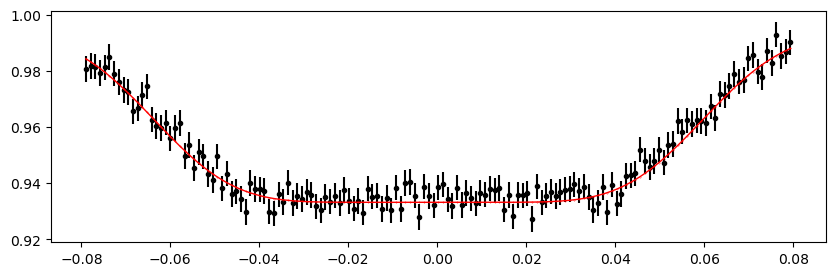

1795.06696 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.00it/s]


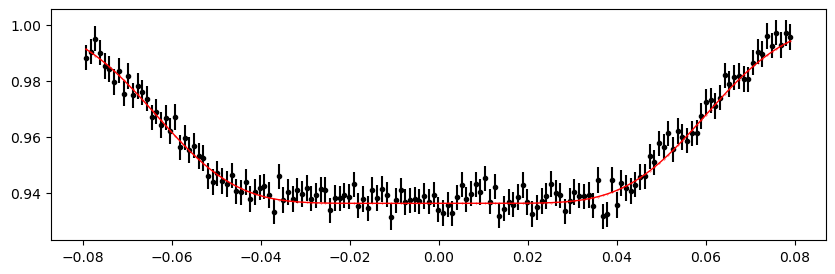

1796.38264 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.96it/s]


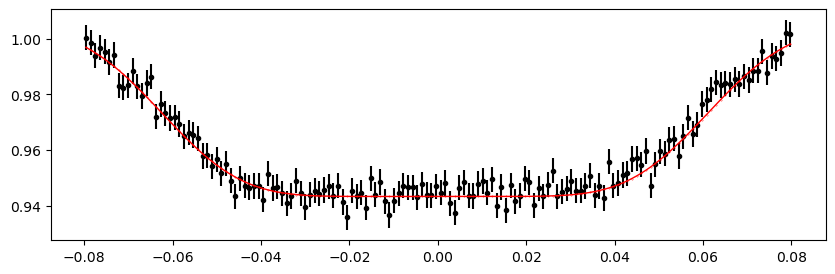

1797.69832 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.36it/s]


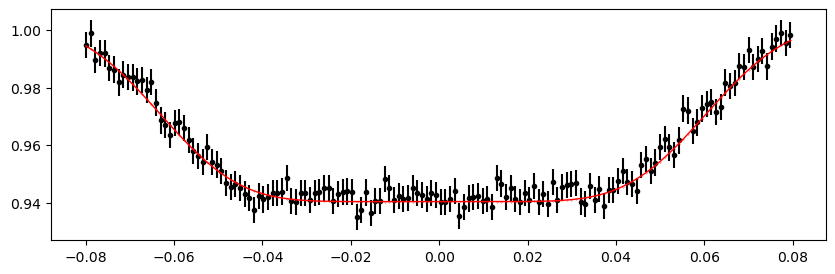

1799.0140000000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.65it/s]


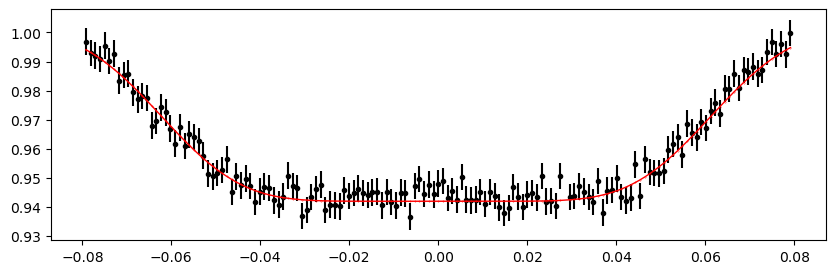

1800.32968 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.39it/s]


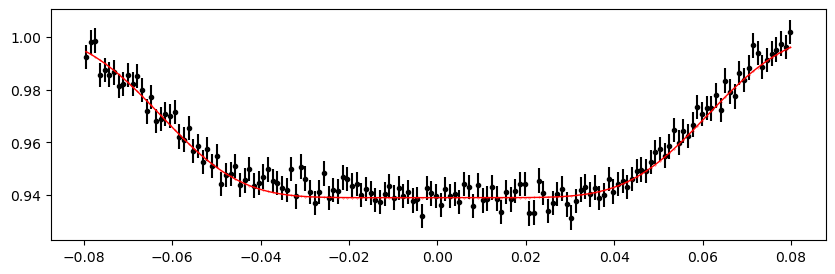

1804.27672 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.79it/s]


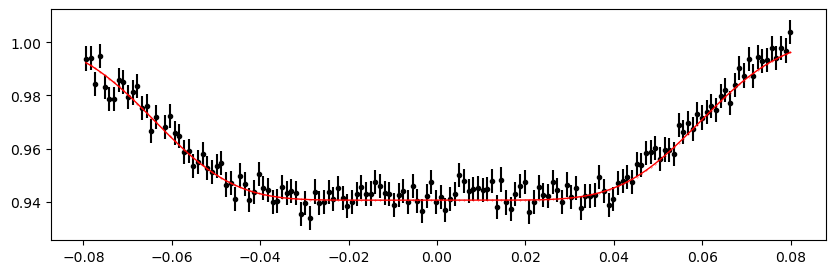

1805.5924 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.97it/s]


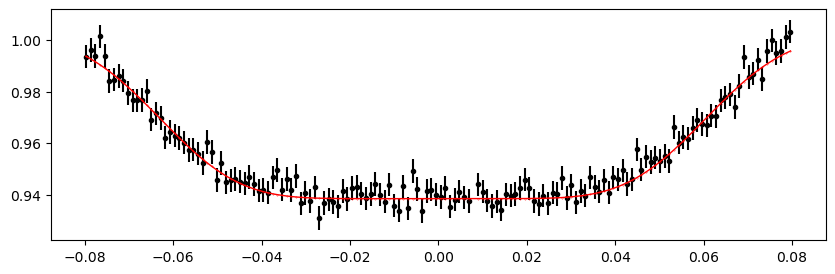

1806.9080800000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.32it/s]


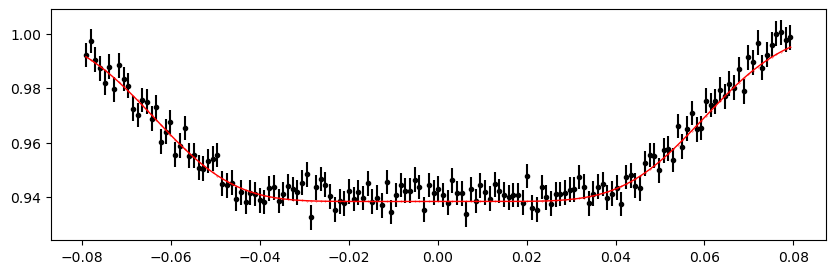

1808.22376 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.63it/s]


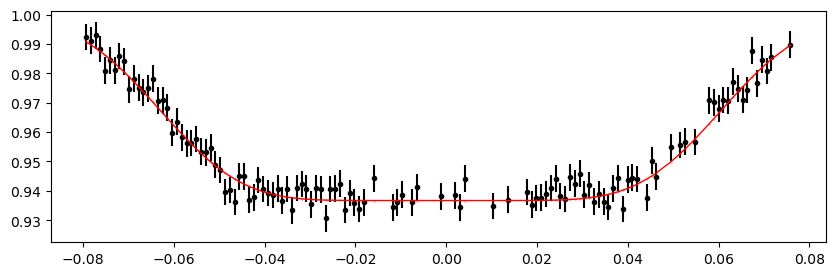

1809.53944 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.61it/s]


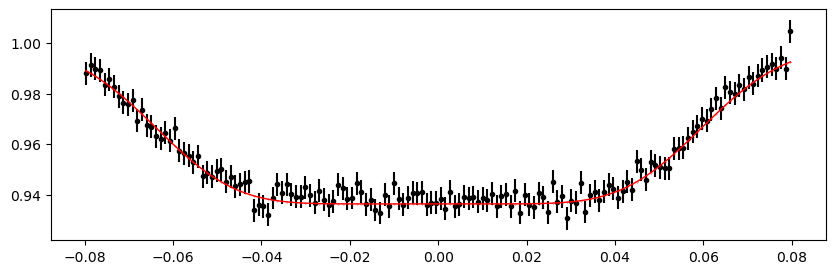

1810.8551200000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.01it/s]


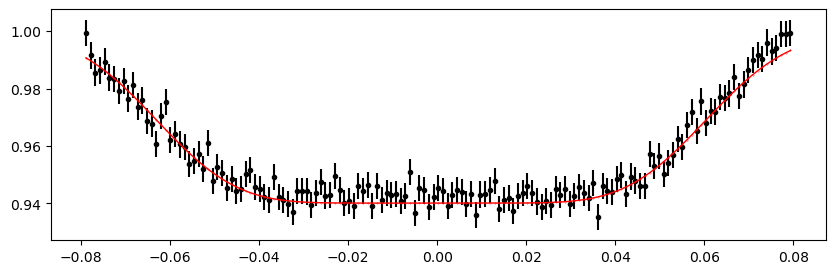

1812.1708 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.80it/s]


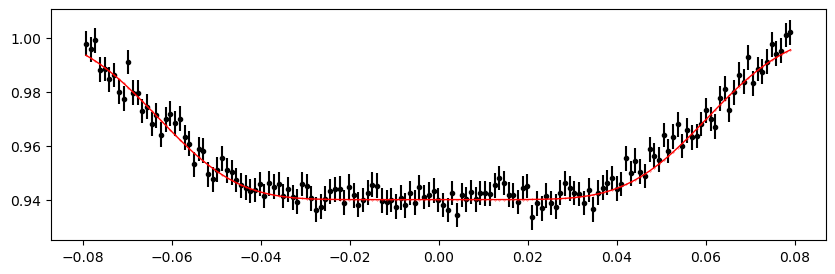

1813.48648 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.40it/s]


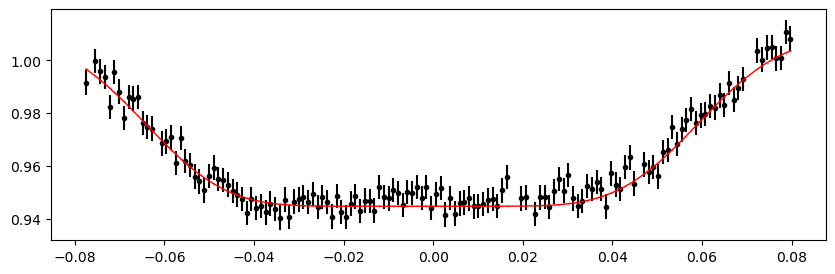

1958.21128 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.12it/s]


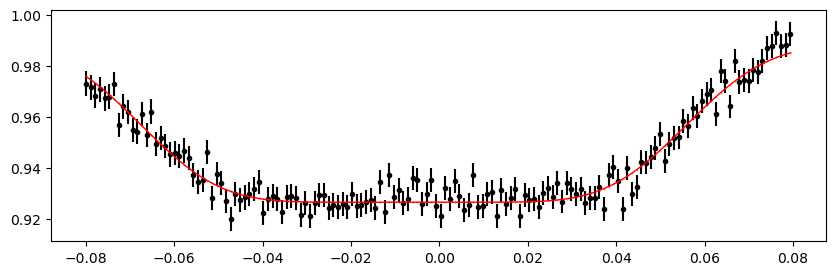

1959.5269600000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.33it/s]


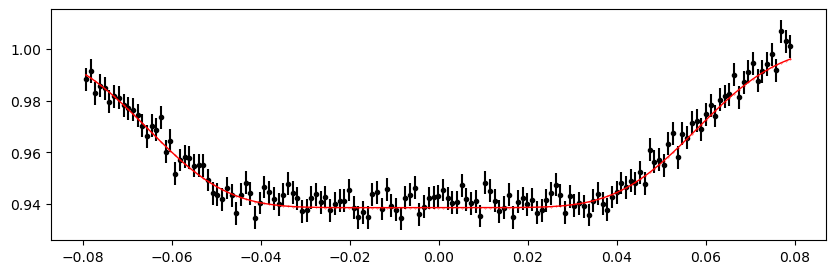

1960.84264 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.63it/s]


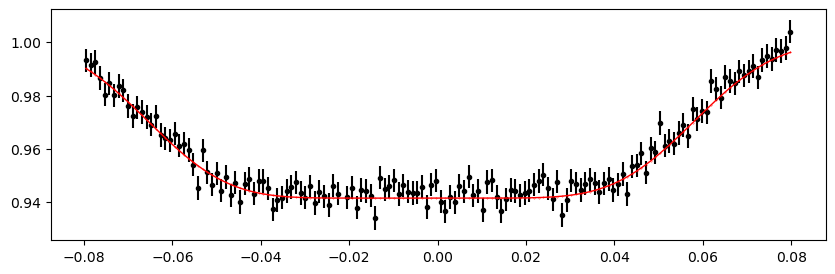

1962.15832 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.82it/s]


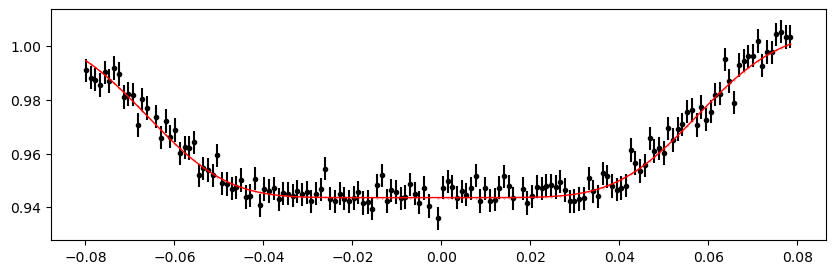

1963.4740000000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.24it/s]


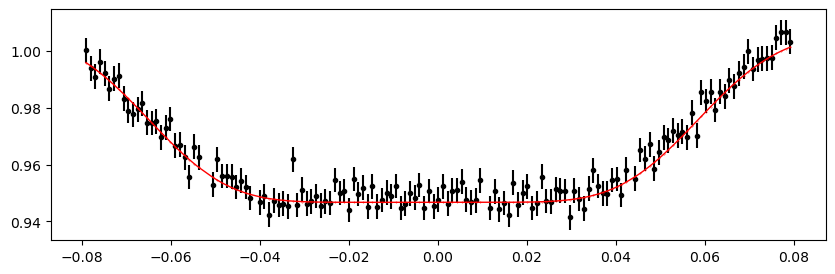

1964.78968 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.32it/s]


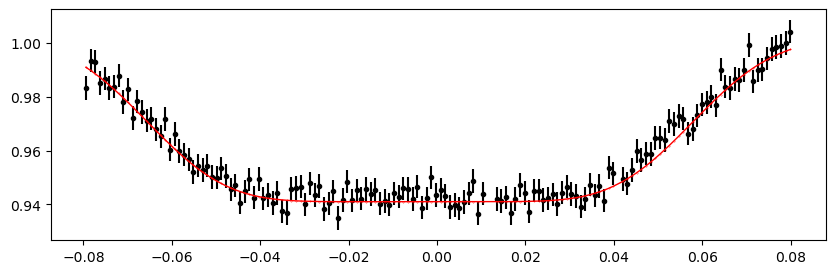

1966.10536 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.94it/s]


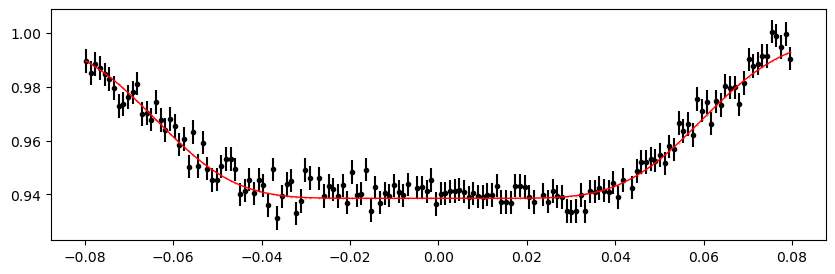

1967.4210400000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.91it/s]


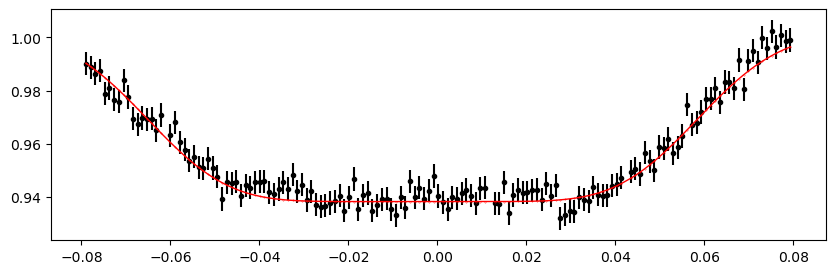

1970.0524 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.18it/s]


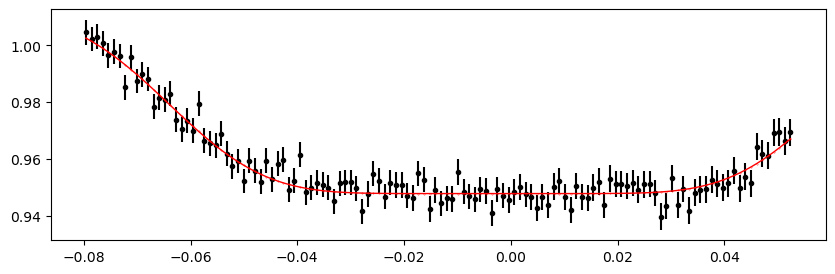

1972.6837600000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.85it/s]


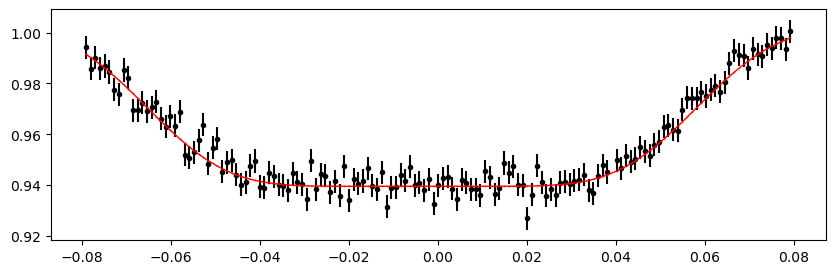

1973.99944 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.20it/s]


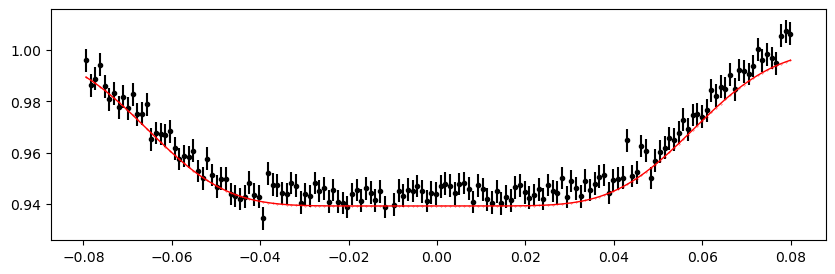

1975.31512 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.20it/s]


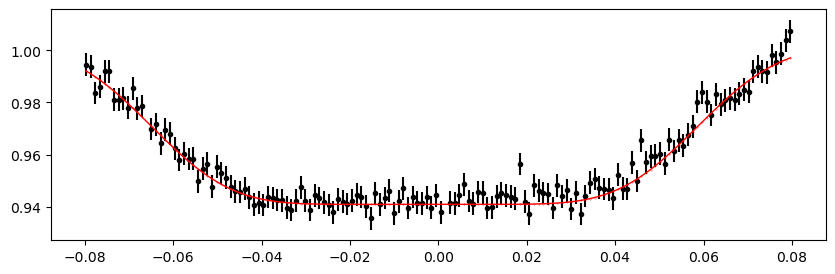

1976.6308000000001 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.46it/s]


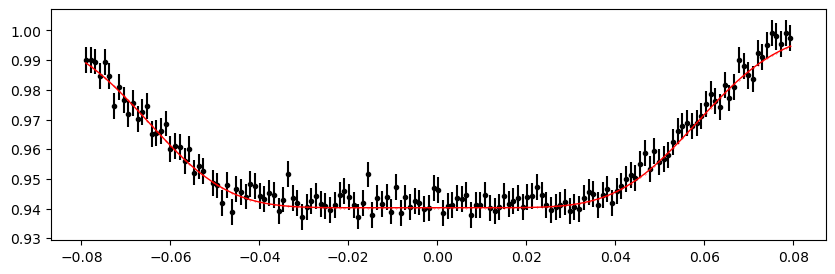

1977.94648 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.17it/s]


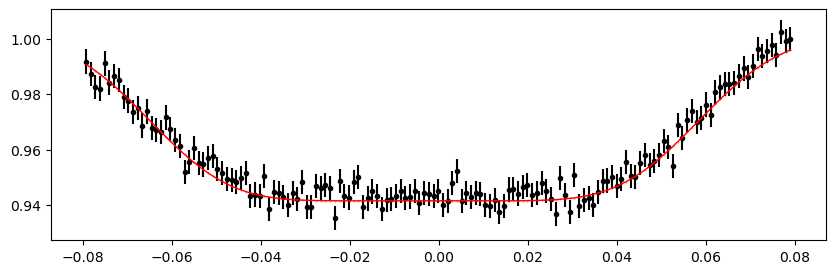

1979.26216 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.81it/s]


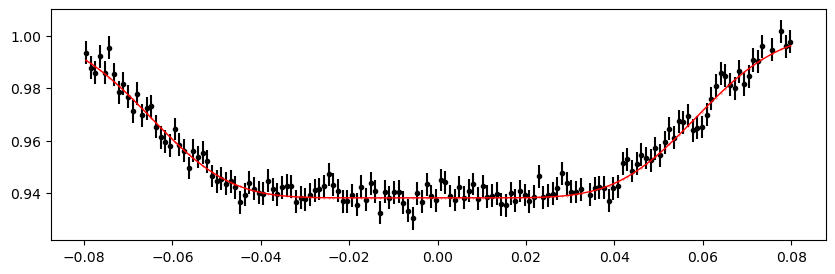

1980.5778400000002 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.87it/s]


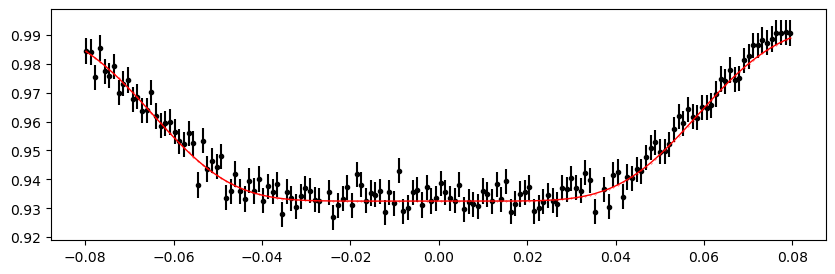

1981.89352 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.95it/s]


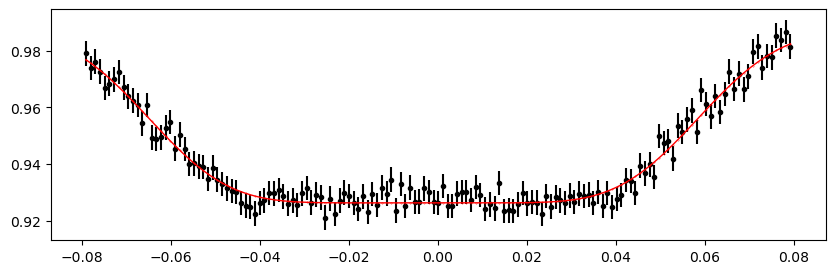

2883.13432 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.66it/s]


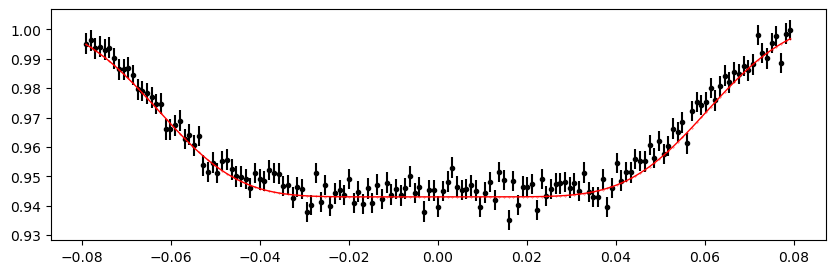

2884.45 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.34it/s]


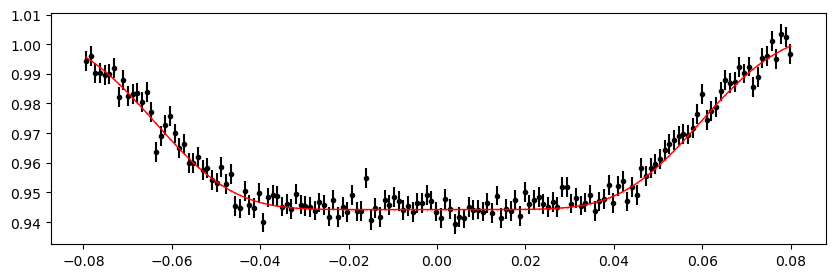

2885.76568 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.51it/s]


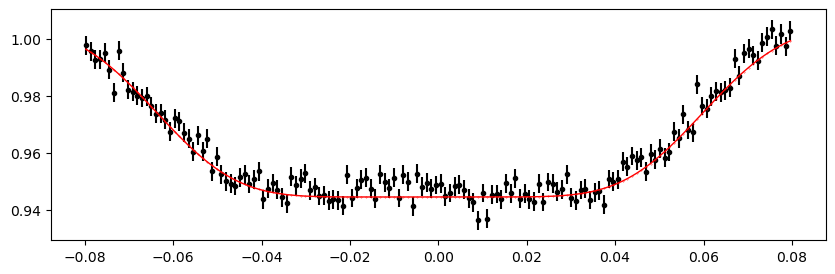

2887.08136 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.22it/s]


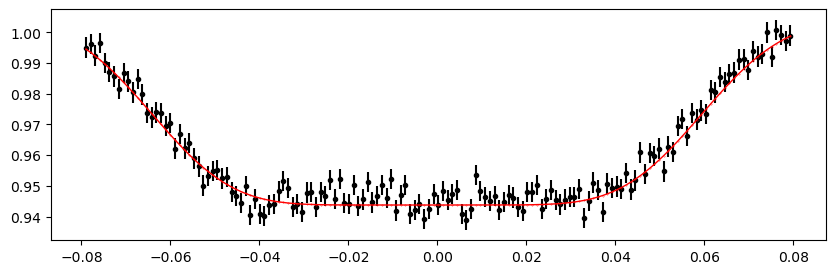

2888.39704 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.63it/s]


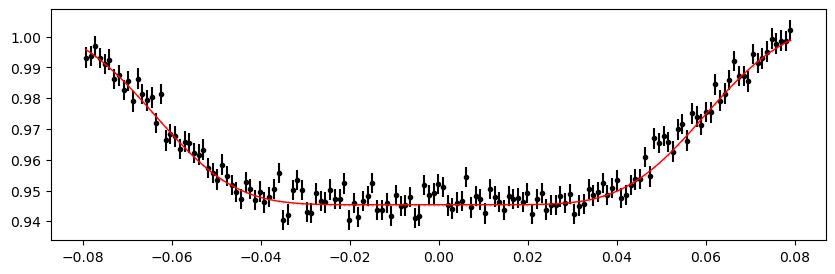

2889.71272 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.90it/s]


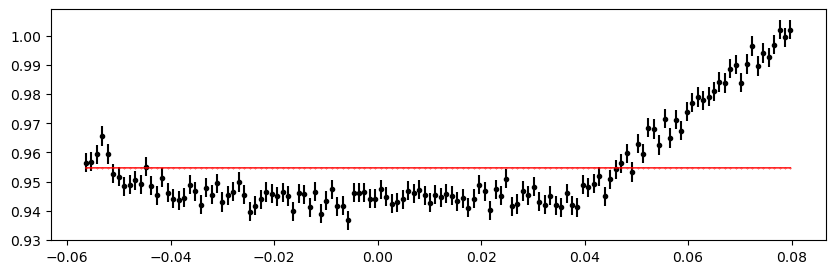

2891.0284 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.48it/s]


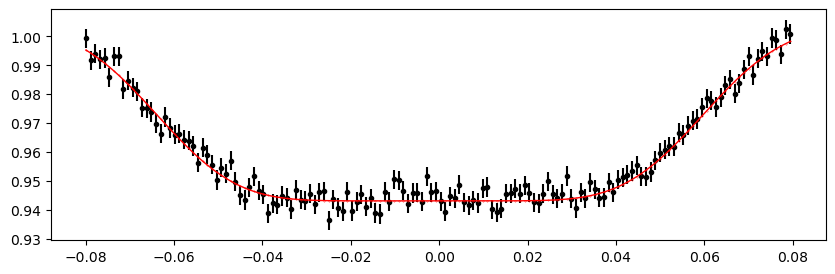

2894.97544 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.84it/s]


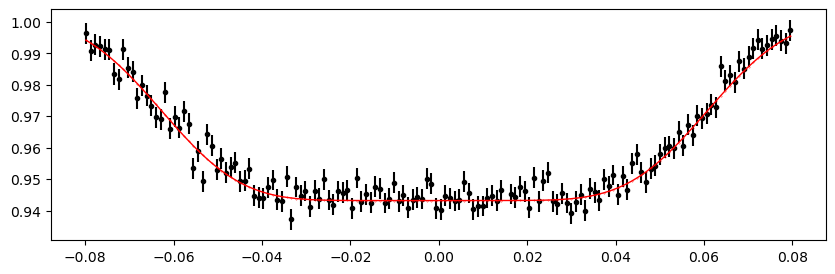

2896.29112 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.76it/s]


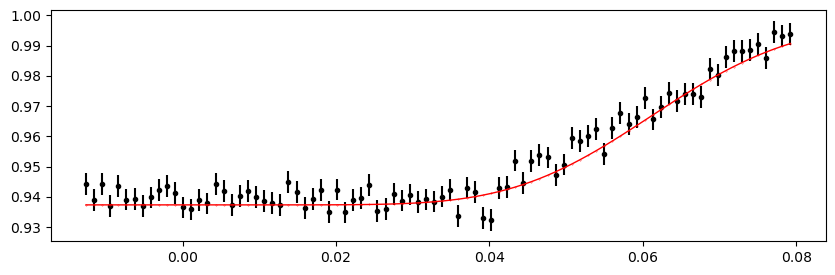

2897.6068 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.04it/s]


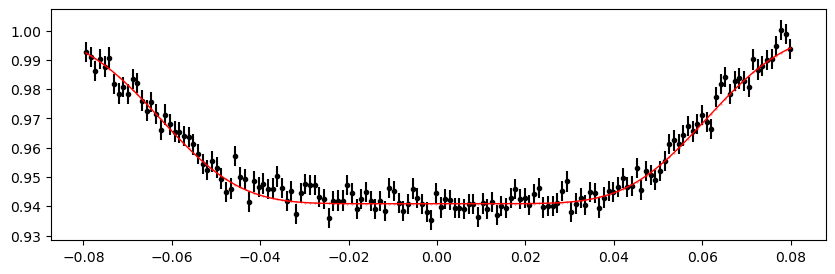

2898.92248 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.10it/s]


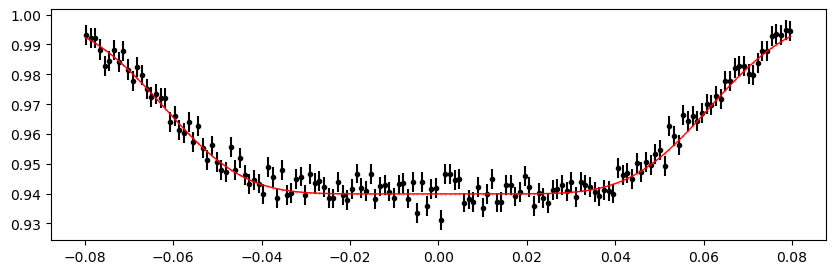

2900.23816 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.21it/s]


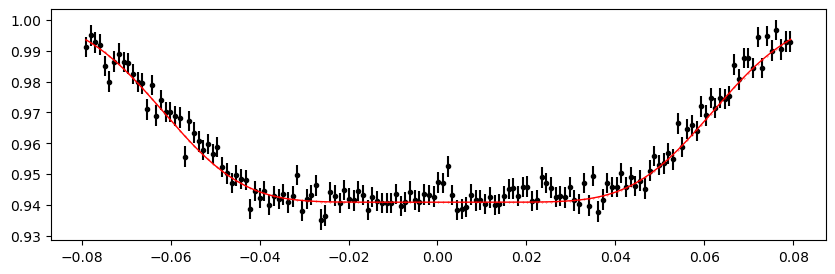

2901.55384 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.03it/s]


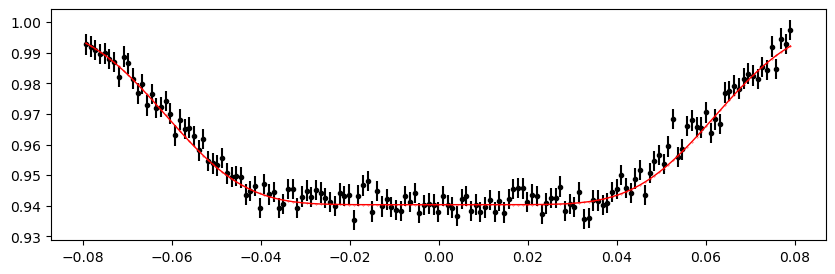

2902.86952 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.95it/s]


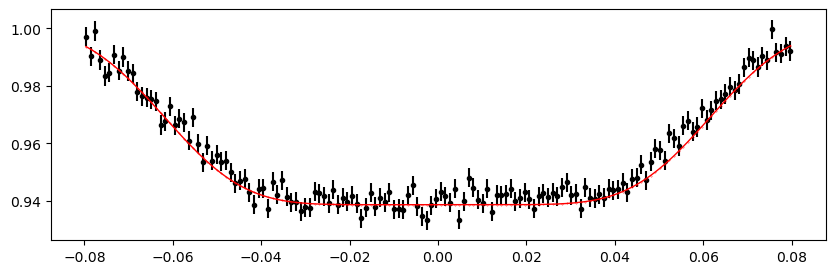

2904.1852 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.89it/s]


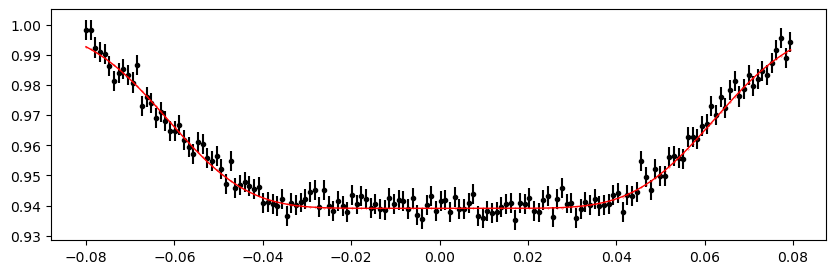

2905.50088 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.57it/s]


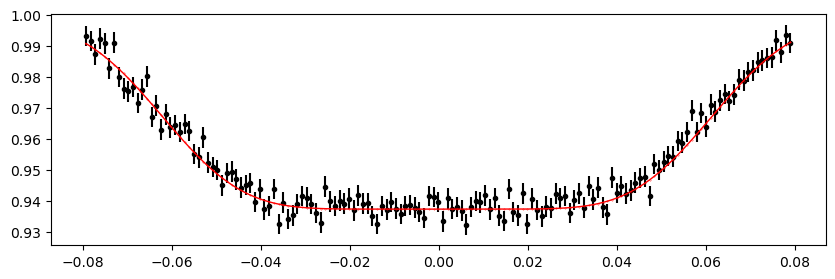

2906.81656 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.46it/s]


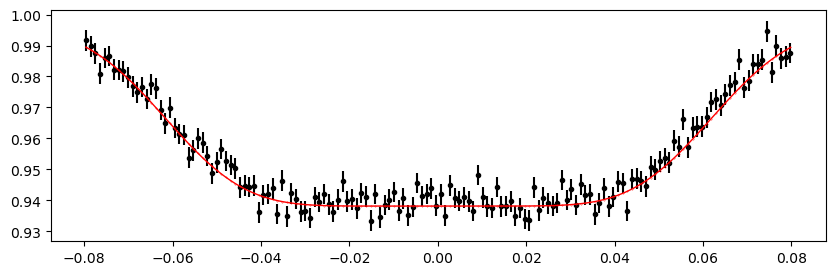

2908.13224 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.23it/s]


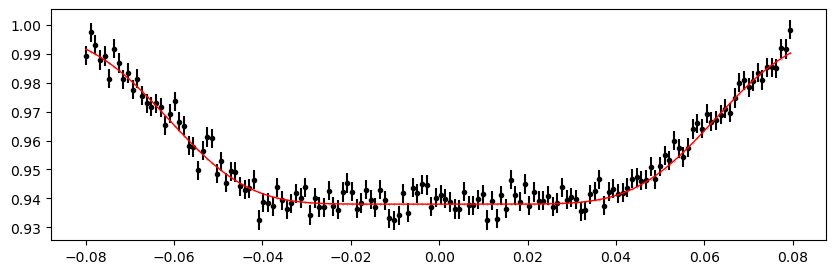

2909.44792 1.0014983159369468 -0.06142750369474018 0.36239873882879814


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.70it/s]


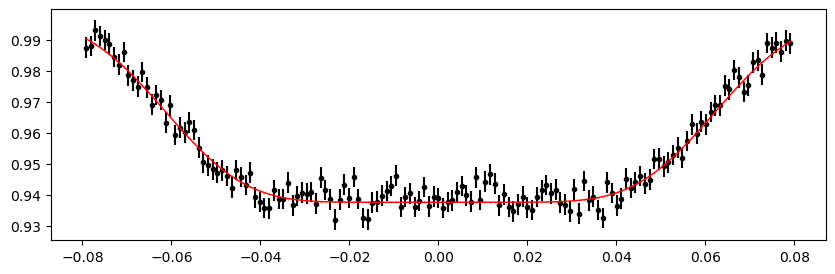

In [38]:
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path)
etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s)

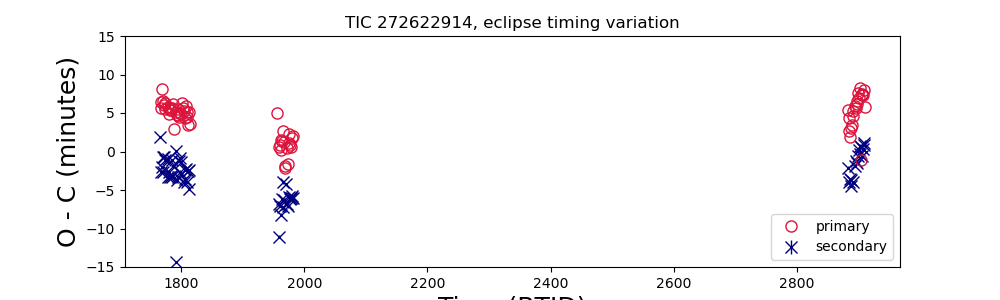

In [56]:
%matplotlib widget

#plot the extracted transit times to check for ETVs

fig = plt.subplots(figsize=(10, 3), sharex=True)

in_df_primary = pd.read_csv(outfile_path)
in_df_secondary = pd.read_csv(outfile_path_s)


in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']

in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']

plt.errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', markeredgecolor = 'crimson', label="primary")
plt.errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
             lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

plt.xlabel("Time (BTJD)", fontsize = 18)
plt.ylabel("O - C (minutes)", fontsize = 18)
plt.title(f"TIC {ticid}, eclipse timing variation")
plt.legend();

# plt.xlim(np.min(in_df_primary['epoch']) - 1, 1820);
# plt.ylim(-15, 15);

#plt.axhline(4.5)
#plt.axhline(-2.16)
plt.show()

## make a periodogram 

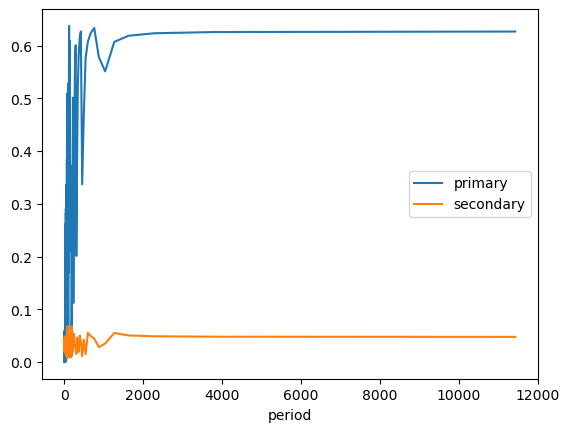

In [48]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()
frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    
plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.show()